## NON TOR/VPN Packet based network classfication and interpretation with Deep Learning and Embedding

Author : Fabien MESLET-MILLET  
**It's a draft !**

# Table of contents

1. [Context](#context)  
2. [Importations](#importations)  
3. [Informations](#informations)  
4. [Set parameters](#set_parameters)  
5. [Load data](#load_data)  
6. [EDA (Exploration Data Analysis)](#eda)   
7. [Preprocessing](#preprocessing)  
8. [Modelisation](#modelisation)  
    8.1 [Learning](#learning)  
    8.2 [Modelisation](#modelisation)  
    8.3 [Learning curves](#learning_curves)  
    8.4 [Accuracy curves](#accuracy_curves)  
    8.5 [Learning rates](#learning_rates)  
    8.6 [Results](#results)  
    8.7 [Conclusion](#modelisation_conclusion)
9. [Interpretation](#interpretation)  
    9.1 [Input space](#input_space)  
    9.2 [Projected space](#projected_space)   
    

# 1. Context <a id="context"></a>

To fill.

# 2. Importations <a id="importations"></a>

In [1]:
# From : https://github.com/broadinstitute/keras-resnet
# !pip install keras-resnet

# From : https://pypi.org/project/keras-bert/
# !pip install keras_bert

# !pip install wikipedia2vec -q
# !wget http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.pkl.bz2
# !bzip2 -dk enwiki_20180420_100d.pkl.bz2

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Linear algebra and data processing
import numpy as np
import pandas as pd
import math
import random

# Get version python/keras/tensorflow/sklearn
from platform import python_version
import sklearn
import keras
import tensorflow as tf

# Loading bar
from tqdm import tqdm

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold

# Folder manipulation
import os
import sys

# Garbage collector
import gc

# Others
import pickle

# Tensorflow importation
from tensorflow.python.framework import ops

# Keras importation
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Concatenate, LSTM, GRU, Dense, concatenate
from keras.layers import Embedding, Reshape
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
import keras.backend as K 
import keras.backend
import keras.layers
import keras.models
import keras.regularizers
from keras.preprocessing.text import Tokenizer

# For images augmentations
import cv2

# Visualizaton
import matplotlib.pyplot as plt
import seaborn as sns

# Get Keras Resnet in Conv1D for fast prototyping
import keras_resnet.models
import keras_resnet.blocks
import keras_resnet.layers

# Wikipedia embedding
#from wikipedia2vec import Wikipedia2Vec

# Gensim for word2Vec
#from gensim.models import Word2Vec
#from gensim.models.callbacks import CallbackAny2Vec

Using TensorFlow backend.


# 3. Informations <a id="informations"></a>

In [2]:
print("Keras version : " + keras.__version__)
print("Tensorflow version : " + tf.__version__)
print("Python version : " + python_version())
print("Sklearn version : " + sklearn.__version__)

Keras version : 2.3.1
Tensorflow version : 1.14.0
Python version : 3.5.6
Sklearn version : 0.20.0


# 4. Set parameters <a id="set_parameters"></a>

In [2]:
MAIN_DIR = "/work/scratch/mesletf/PFE/"
DATA_DIR = "/work/scratch/mesletf/PFE/data/"

DATASET_PATH = "/work/scratch/mesletf/PFE/dataset_last.csv"
DATASET_PORTS_PATH = "/work/scratch/mesletf/PFE/ports.csv"
DATASET_PORTS_PATH = "/work/scratch/mesletf/PFE/embedding.npy"

HEADERS = ['L1', 'L2', 'L3']
GROUPS = ['NON_TOR_VPN', 'VPN', 'TOR']
LABELS = ['Chat', 'Streaming', 'Email', 
         'File_Transfer', 'P2P', 
         'VoIP', 'Web_Browsing']

GROUP = GROUPS[0]
HEADER = HEADERS[2]
EPOCHS = 15
MIN_LENGTH = 768
EXT_NAME = "{}_{}_{}_{}".format(GROUP, str(HEADER), str(MIN_LENGTH), EPOCHS)

PACKET_CHANNELS = 1
NAMESERVER_LENGTH = 6

PACKET_SHAPE_2D_BIT = (111, 111, PACKET_CHANNELS)
PACKET_SHAPE_2D_INT = (40, 40, PACKET_CHANNELS)

PACKET_SHAPE_1D_BIT = (12288, PACKET_CHANNELS)
PACKET_SHAPE_1D_INT = (1536, PACKET_CHANNELS)

# Set graph font size
sns.set(font_scale=1.2)

# 5. Load data <a id="load_data"></a>

In [3]:
def load_data():
    data = pd.read_csv(DATASET_PATH)
    return data

In [4]:
%%time
data = load_data()

CPU times: user 1min 12s, sys: 7.63 s, total: 1min 19s
Wall time: 1min 19s


In [5]:
print("Shape of data : {}".format(data.shape))

Shape of data : (39355140, 20)


# 6. EDA (Exploration Data Analysis) <a id="eda"></a>

# 7. Preprocessing <a id="preprocessing"></a>

In [6]:
def save_object(processing, path, name):
    with open("{}/{}".format(path, name),"wb") as f:
        pickle.dump(processing,f)

In [7]:
def load_object(path, name):
    with open("{}/{}".format(path, name),"rb") as f:
        processing = pickle.load(f)
    return processing

In [8]:
class Processing:
    
    def __init__(self, dataset):
        self.dataset = dataset.copy()
        
        self.form = None
        self.map_dict  = None
        self.inv_map_dict  = None
        
        self.dict_nameserver = None
        self.inv_dict_nameserver = None
        
        self.dict_ports = None
        self.inv_dict_ports = None
        
        self.nameserver = None
    
    def __remove_header(self, packet, size=0):
        new_packet = np.lib.pad(packet.ravel()[size:], 
                                         (0,size), 
                                         'constant', 
                                          constant_values=(0))
        return np.reshape(new_packet, packet.shape)
    
    def remove_l1(self, data_array, form='int'):
        condition = (self.dataset['L1'] == 'Ether')
        indexes = self.dataset[condition].index.values
        if(form=='int'):
            header_length = 14
        else:
            header_length = 14 * 8
        for i in indexes:
            # Remove all Ethernet header for packet which have ethernet header
            data_array[i] = self.__remove_header(
                data_array[i], 
                size=header_length)
            
    def remove_l2(self, data_array, form='int'):
        self.remove_l1(data_array, form=form)
        indexes = self.dataset.index.values
        if(form=='int'):
            header_length = 20
        else:
            header_length = 20 * 8
        for i in indexes:
            # Remove IP header for all packet
            data_array[i] = self.__remove_header(
                data_array[i], 
                size=header_length)
            
    def remove_l3(self, data_array, form='int'):
        # Remove_l1
        self.remove_l1(data_array, form=form)

        # Start UDP
        condition = (self.dataset['L3'] == 'UDP')
        indexes_udp = self.dataset[
            condition].index.values
        for i in indexes_udp:
            if(form=='int'):
                data_array[i] = self.__remove_header(
                    data_array[i], 
                    size=20+8)
            else:
                data_array[i] = self.__remove_header(
                    data_array[i], 
                    size=(20+8)*8)

        # Start TCP
        condition = (self.dataset['L3'] == 'TCP')
        indexes_tcp = self.dataset[condition].index.values
        for i in indexes_tcp:
            # Remove header depend on TCP length 
            # /!\ To change if data already in int format !!!
            if(form=='int'):
                header_length_value = (data_array[i].ravel()[32]).astype(int)
                header_length_int = int('{0:08b}'.format(header_length_value)[0:4], 2)
                header_length = 20 + header_length_int * 4
            else:
                header_length_bit = (data_array[i].ravel()[32*8:+32*8+4]).astype(str)
                header_length_int = int("".join(header_length_bit),2)
                header_length = (20 + header_length_int * 4) * 8
                
            # We had IP header length   
            data_array[i] = self.__remove_header(
                data_array[i], 
                size=header_length)
            
    def label_to_int(self, keras_mode=True):
        self.map_dict = {}
        values = np.unique(self.dataset['label'].values)
        for i, value in enumerate(values):
            if(keras_mode):
                self.map_dict[value] = i
            else:
                self.map_dict[value] = i + 1 

        self.dataset['label'] = self.dataset['label'].map(
            self.map_dict).astype(int)
        
        self.inv_map_dict = {v: k for k, v in self.map_dict.items()}
    
    def int_to_label(self):        
        self.dataset['label'] = self.dataset['label'].map(
            self.inv_map_dict).astype(str) 
        
    def fit_processing_header(self, header, data_array, form):
        if(header == 'L1'):
            self.remove_l1(data_array, form=form)
        elif(header == 'L2'):
            self.remove_l2(data_array, form=form)
        elif(header == 'L3'):
            self.remove_l3(data_array, form=form)
        else:
            pass
    
    def fit_under_sampling(self, n, 
                           min_length, 
                           weights=None):
        # With keras_mode = 0 we start from 0
        self.label_to_int(keras_mode=False)
        # If weights == False we sample in equals quantity for each class/group 
        if(weights is not None): # Weight uniquement sur les labels
            self.dataset = self.dataset.sample(
                n=n, weights=weights, random_state=42, 
                replace=False).reset_index(drop=True)
        else:
            df_result = pd.DataFrame()
            n_class = int(n/len(self.map_dict))
            class_dict = self.dataset['label'].value_counts().to_dict()
            class_dict = sorted(class_dict.items(), 
                                key=lambda kv: kv[1])
            debt_files = 0
            for v, _ in class_dict:#self.map_dict.values():
                filename_dict = self.dataset[
                    self.dataset['label'] == v]['filename'].value_counts().to_dict()
                filename_dict = sorted(filename_dict.items(), 
                                       key=lambda kv: kv[1])
                n_files = int(np.ceil(n_class/len(filename_dict)))
                for f, q in filename_dict:
                    if(q < n_files):
                        df_tmp = self.dataset[(self.dataset['label'] == v) & 
                                              (self.dataset['filename'] == f)]
                        debt_files = debt_files + (n_files - q)
                    else:
                        if(q >= n_files+debt_files):
                            n_max = n_files+debt_files
                        else:
                            n_max = q

                        df_tmp = self.dataset[
                            (self.dataset['label'] == v) & 
                            (self.dataset['filename'] == f)].sample(n=n_max, 
                                                                    random_state=42,
                                                                    replace=False)
                        debt_files = debt_files - (n_max - n_files)
                    df_result = pd.concat([df_result, df_tmp])

            self.dataset = df_result.reset_index(drop=True)
            
        self.int_to_label()
        
    def fit_filter_dataset(self, group, others, min_length):  
        if(group is None):
            if(not others):
                condition = (self.dataset['others'] == others)      
        else:
            if(others):
                condition = (self.dataset['group'] == group)
            else:
                condition = ((self.dataset['group'] == group) & 
                            (self.dataset['others'] == others))

        self.dataset = self.dataset[
                    condition].reset_index(drop=True) 
        
        condition_length = (
            self.dataset['total_len'] >= min_length)
        self.dataset = self.dataset[
            condition_length].reset_index()
        
    def __apply_nameserver(self, nameservers):
        if(not pd.isnull(nameservers[0])):
            return nameservers[0]
        if(not pd.isnull(nameservers[1])):
            return nameservers[1]
        if(not pd.isnull(nameservers[2])):
            return nameservers[2]
        
    def __apply_split_nameserver(self, nameserver):
        columns = ["level_{}".format(i) for i in range(NAMESERVER_LENGTH)]

        if(pd.isnull(nameserver)):
            nameserver_split =  ["<PAD>"] * NAMESERVER_LENGTH
        else:
            length = len(nameserver.split('.')) - 1
            nameserver_split = nameserver.split('.')[:-1]

            nameserver_split.reverse()

            pad = ["<PAD>"] * (NAMESERVER_LENGTH - length)
            nameserver_split = pad + nameserver_split

        return pd.Series(nameserver_split, columns)
    
    def __apply_tokenize(self, columns):
        tokenizer = Tokenizer(filters='',
                      char_level=False,
                      lower=False)
        
        corpus = self.dataset[columns].values.ravel()
        tokenizer.fit_on_texts(corpus)
        
        self.dict_nameserver = tokenizer.index_word
        self.inv_dict_nameserver = {v: k for k, v in self.dict_nameserver.items()}
        
        for col in columns:
            self.dataset[col] = self.dataset[col].map(self.inv_dict_nameserver)
            
        self.nameservers = self.dataset[columns]  
        
    def fit_nameserver(self):
        columns = ['DNS_nameserver', 'TLS_nameserver', 'QUIC_nameserver']
                                
        # Select nameserver to use (TLS/DNS/QUIC)
        self.dataset['nameserver'] = self.dataset[columns].apply(
            self.__apply_nameserver, axis=1)
        self.dataset = self.dataset.drop(columns, axis=1)
                    
        # Split nameserver
        nameservers_split = self.dataset['nameserver'].apply(
            self.__apply_split_nameserver)
        self.dataset = pd.concat([self.dataset, nameservers_split], axis=1)
        #self.dataset = self.dataset.drop(['nameserver'], axis=1)
        
        # Tokenize
        columns = nameservers_split.columns
        self.__apply_tokenize(columns)
        
    def fit_ports(self):        
        tokenizer = Tokenizer(filters='',
              char_level=False,
              lower=False)
        
        corpus = self.dataset['L4'].values
        tokenizer.fit_on_texts(corpus)
        
        self.dict_ports = tokenizer.index_word
        self.inv_dict_ports = {v: k for k, v in self.dict_ports.items()}
        
        self.dataset['L4'] = self.dataset['L4'].map(self.inv_dict_ports)  
        
        
    def apply_dict_ports(self, dict_ports):
        self.dataset['L4'] = self.dataset['L4'].map(dict_ports)
        
    def apply_dict_nameserver(self, dict_nameserver, columns):
        col_nameservers = ['DNS_nameserver', 'TLS_nameserver', 'QUIC_nameserver']
        
        # Select nameserver to use (TLS/DNS/QUIC)
        self.dataset['nameserver'] = self.dataset[col_nameservers].apply(
            self.__apply_nameserver, axis=1)
        self.dataset = self.dataset.drop(col_nameservers, axis=1)
        
        # Split nameserver
        nameservers_split = self.dataset['nameserver'].apply(
            self.__apply_split_nameserver)
        self.dataset = pd.concat([self.dataset, nameservers_split], axis=1)
        
        for col in columns:
            self.dataset[col] = self.dataset[col].map(dict_nameserver)
            self.dataset[col] = self.dataset[col].fillna(0)
            
        self.nameservers = self.dataset[columns]

In [10]:
# Minimum number of packet for a class multiply by the minimum number of class
# The goal is to get the same number of sample per class for each group
condition = ((data['group'] == GROUP) & (data['others'] == False))
n = 11564 * data[condition]['label'].value_counts().shape[0] # 11564

processing = Processing(dataset=data)
processing.fit_filter_dataset(group=GROUP, others=False, min_length=MIN_LENGTH)
processing.fit_under_sampling(n=n, min_length=MIN_LENGTH, weights=None)
processing.label_to_int(keras_mode=True)
processing.fit_nameserver()
processing.fit_ports()
#save_object(processing, 
#                path=MAIN_DIR+"data_save/processings", 
#                name="processing_"+EXT_NAME)

In [9]:
# Load data under-sampling
processing = load_object(
    path=MAIN_DIR+"data_save/processings", 
    name="processing_"+EXT_NAME)

In [12]:
processing.dict_ports

{1: 'Raw',
 2: 'TLS',
 3: 'HTTP',
 4: 'SSH',
 5: 'SMTPS',
 6: 'QUIC',
 7: 'POP3S',
 8: 'IMAPS',
 9: 'BITTORRENT',
 10: 'FTPS',
 11: 'IRC'}

In [244]:
processing.dataset.head()

,index,group,ip_dst,ip_src,label,dport,sport,total_len,L1,L2,...,application,gate,encrypt,nameserver,level_0,level_1,level_2,level_3,level_4,level_5
0,15318676,NON_TOR_VPN,131.202.240.87,178.237.24.202,0,64364.0,443.0,635,Ether,IP,...,ICQ chat,0,1,None,1,1,1,1,1,1
1,15318743,NON_TOR_VPN,131.202.240.87,178.237.24.202,0,64364.0,443.0,487,Ether,IP,...,ICQ chat,0,1,None,1,1,1,1,1,1
2,15318756,NON_TOR_VPN,131.202.240.87,178.237.19.103,0,64201.0,443.0,403,Ether,IP,...,ICQ chat,0,1,None,1,1,1,1,1,1
3,15318770,NON_TOR_VPN,131.202.240.87,178.237.24.202,0,64364.0,443.0,471,Ether,IP,...,ICQ chat,0,1,None,1,1,1,1,1,1
4,15318831,NON_TOR_VPN,131.202.240.87,178.237.24.202,0,64364.0,443.0,431,Ether,IP,...,ICQ chat,0,1,None,1,1,1,1,1,1


In [267]:
processing.dataset['L4'].value_counts()

1     27932
2     18844
3     14110
4      5321
5      4811
6      3691
7      2778
8      2554
9       626
10      331
11        5
Name: L4, dtype: int64

In [98]:
processing.map_dict

{'Chat': 0,
 'Email': 1,
 'File_Transfer': 2,
 'P2P': 3,
 'Streaming': 4,
 'VoIP': 5,
 'Web_Browsing': 6}

In [245]:
processing.dataset['label'].value_counts()

2    11585
5    11581
4    11575
1    11568
6    11565
3    11565
0    11564
Name: label, dtype: int64

In [246]:
print("Shape of dataset id {}".format(processing.dataset.shape))

Shape of dataset id (81003, 25)


**Comment** : I decide to perform **Under Sampling** on the notebook due to technical reason. On CNES cluster I have 94 Gb of RAM, an Nvidia GPU P100 for 12 hours and 9 cores on CPU. The Notebook close after 5-10 min of inactivity. So if the training is to long I need to wait behind the notebook and simulate activity (i.e. move mouse, click...etc).

In future, I will deploy the model on script (not on Notebook) and I will run it on the cluster for multiple hours (24-36 hours) with **focal loss** (to solve unbalance data problem). In theory this will give better result because we will use more data. I will use this notebook to perform proportionnal under sampling (keep the same label proportion) and hyperparameter my model before deploying on cluster.

Nowadays, to my mind, it's sufficient to deploy the model on Notebook in order to compare performance and get interpretation. It will be useful in case we want to have the best model for real application.

# 8. Modélisation <a id="modelisation"></a>

**Note** : Data in input of models are already normalized between 0 and 1. Keras Generator is able to learn from disk or from RAM.

In [10]:
def save_model(model, history, path, name):
    model.save("{}/{}.h5".format(path, name))
    with open("{}/history_{}".format(path, name),"wb") as f:
        pickle.dump(history,f)

In [11]:
def load_model(path, name, custom_objects=None):
    model = keras.models.load_model('{}/{}.h5'.format(path, name), 
                                    custom_objects=custom_objects)
    with open("{}/history_{}".format(path, name),"rb") as f:
        history = pickle.load(f)
    return model, history

In [186]:
def save_models(models, histories, path, name):
    for model, history, i in zip(models, histories, range(5)):
        model.save("{}/{}_{}.h5".format(path, name, i))
        with open("{}/history_{}_{}".format(path, name, i),"wb") as f:
            pickle.dump(history,f)

In [43]:
def load_models(path, name, custom_objects=None):
    models = []
    histories = []
    for i in range(5):
        print("Model {} loaded !".format(i))
        model = keras.models.load_model('{}/{}_{}.h5'.format(path, name, i), 
                                        custom_objects=custom_objects)
        with open("{}/history_{}_{}".format(path, name, i),"rb") as f:
            history = pickle.load(f)
            
        models.append(model)
        histories.append(history)
    return models, histories

In [14]:
# https://github.com/umbertogriffo/focal-loss-keras/blob/master/losses.py
def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)

    return categorical_focal_loss_fixed

In [15]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,
                 data,
                 index_embedding,
                 #embedding,
                 protocol,
                 dns,
                 list_IDs,
                 data_loaded=False,
                 labels=None,
                 batch_size=32,
                 dim=None, # '1d' or '2d'
                 n_channels=1, 
                 form=None, #'bits' or 'int'
                 n_classes=7,
                 group=None,
                 mode='fit',
                 normalize=True,
                 shuffle=True,
                 header=None,
                 random_state=42):
        
        'Initialization'
        self.data = data
        self.index_embedding = index_embedding
        #self.embedding = embedding
        self.protocol = protocol
        self.dns = dns
        self.data_loaded = data_loaded
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.form = form
        self.n_classes = n_classes
        self.group = group
        self.mode = mode
        self.normalize = normalize
        self.shuffle = shuffle
        self.header = header
        self.random_state = random_state
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if(self.mode == 'fit'):
            return int(np.floor(len(self.list_IDs) / self.batch_size))
        else:
            return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
    
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        inputs = []

        # Generate input
        if(self.data is not None):
            X = self.__generate_X(list_IDs_batch)
            if(self.normalize):
                X = X / 255.  
            inputs.append(X)
        
        if(self.index_embedding is not None):
            E = self.__generate_E(list_IDs_batch)
            inputs.append(E)
        
        if(self.protocol is not None):
            P = self.__generate_P(list_IDs_batch)
            inputs.append(P)
            
        if(self.dns is not None):
            D = self.__generate_D(list_IDs_batch)
            inputs.append(D)

        # Generate target or predict    
        if(self.mode == 'fit'):
            y = self.__generate_y(list_IDs_batch)
            return inputs, y
        
        elif self.mode == 'predict':
            return inputs
        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
            
    def __generate_D(self, list_IDs_batch): # Apply layer modification
        'Generates data containing batch_size samples'
        # Check if data are loaded in array or from disk
        # Initialization
        D = np.empty((len(list_IDs_batch), NAMESERVER_LENGTH))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            D[i,] = self.dns[i].reshape((NAMESERVER_LENGTH))#:index+1
        return D
            
    def __generate_P(self, list_IDs_batch): # Apply layer modification
        'Generates data containing batch_size samples'
        # Check if data are loaded in array or from disk
        # Initialization
        P = np.empty((len(list_IDs_batch), 1))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            P[i,] = self.protocol[i].reshape((1,1))#:index+1
        return P
            
    def __generate_E(self, list_IDs_batch): # Apply layer modification
        'Generates data containing batch_size samples'
        # Check if data are loaded in array or from disk
        # Initialization
        E = np.empty((len(list_IDs_batch), 1))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            E[i,] = self.index_embedding[i]
        return E

    def __generate_X(self, list_IDs_batch): # Apply layer modification
        'Generates data containing batch_size samples'
        # Check if data are loaded in array or from disk
        if(self.data_loaded):
            X = self.__generate_X_from_array(list_IDs_batch)
        else:
            X = self.__generate_X_from_disk(list_IDs_batch)
            X = self.__processing_header(X)
        return X
    
    def __generate_X_from_disk(self, list_IDs_batch):
        # Initialization
        X = np.empty((len(list_IDs_batch), 1), dtype='|S496')
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            # Store sample 
            X[i,] = np.load(DATA_DIR + self.data[ID])
           
        X_transform = self.__transform_packet_batch(X)
        return X_transform
        
    def __generate_X_from_array(self, list_IDs_batch):
        # Initialization
        X = np.empty((len(list_IDs_batch), *self.dim))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            # Store sample
            X[i,] = self.data[ID]
    
        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            # Generate data
            y[i, ] = self.labels[ID]

        return keras.utils.to_categorical(y, num_classes=self.n_classes)


    def __transform_packet_int(self, packet_bytes):
        packet_int = [int(byte) for byte in packet_bytes[0]]  
        packet_int_array = np.array(packet_int) 
    
        packet_int_array_pad = np.lib.pad(packet_int_array, 
                                (0,self.dim[0]*self.dim[1]-packet_int_array.shape[0]), 
                                'constant', constant_values=(0))
        
        packet_int_array_pad = np.reshape(packet_int_array_pad, self.dim)
        
        return packet_int_array_pad


    def __transform_packet_bits(self, payload_bytes):
        payload_bits = ''.join(format(byte, '08b') for byte in payload_bytes[0])

        # Save data into a np_array
        def split(bits): 
            return [bit for bit in bits]  

        payload_bits_array = np.array(split(payload_bits), dtype=np.int8) 
        
         # We fill by 0 the empty space
        packet_bits_array_pad = np.lib.pad(payload_bits_array, 
                           (0,self.dim[0]*self.dim[1]-payload_bits_array.shape[0]), 
                           'constant', constant_values=(0))
        
        packet_bits_array_pad = np.reshape(packet_bits_array_pad, self.dim)
        
        return payload_bits_array_pad
    
    
    def __transform_packet_batch(self, packet_batch):
        if(len(self.dim) == 2):
            if(self.form == 'bit'):
                packet_transform = np.apply_along_axis(self.__transform_packet_bits, 
                                                       1, packet_batch)
            else:
                packet_transform = np.apply_along_axis(self.__transform_packet_int, 
                                                       1, packet_batch)
        else:
            if(self.form == 'bit'):
                packet_transform = np.apply_along_axis(self.__transform_packet_bits, 
                                                       1, packet_batch)
            else:
                packet_transform = np.apply_along_axis(self.__transform_packet_int, 
                                                       1, packet_batch)
        
        return packet_transform.astype(np.int8)
    
    def __processing_header(self, data_array):
        if(self.header == 'L1'):
            self.remove_l1(data_array)
        elif(self.header == 'L2'):
            self.remove_l2(data_array)
        elif(self.header == 'L3'):
            self.remove_l2(data_array)
    
    def __remove_header(self, packet, size=0):
        new_packet = np.lib.pad(packet.ravel()[size:], 
                                         (0,size), 
                                         'constant', 
                                          constant_values=(0))
        return np.reshape(new_packet, packet.shape)
    
    def __remove_l1(self, list_IDs_batch, data_array):
        condition = (
            self.data.iloc[list_IDs_batch]['L1'] == 'Ether')
        indexes = self.data.iloc[
            list_IDs_batch][condition].index.values
        
        if(self.form=='int'):
            header_length = 14
        else:
            header_length = 14 * 8
            
        for i in indexes:
            # Remove all Ethernet header for packet which have ethernet header
            data_array[i] = self.__remove_header(
                data_array[i], 
                size=header_length)
            
    def __remove_l2(self, list_IDs_batch, data_array):
        self.__remove_l1(list_IDs_batch, data_array)
        indexes = self.data.iloc[list_IDs_batch].index.values
        
        if(form=='int'):
            header_length = 20
        else:
            header_length = 20 * 8
            
        for i in indexes:
            # Remove IP header for all packet
            data_array[i] = self.__remove_header(
                data_array[i], 
                size=header_length)
            
    def __remove_l3(self, list_IDs_batch, data_array):
        # Remove_l1
        self.__remove_l1(list_IDs_batch, data_array)

        # Start UDP
        condition = (self.data.iloc[
            list_IDs_batch]['L3'] == 'UDP')
        indexes_udp = self.data.iloc[
            list_IDs_batch][condition].index.values
        for i in indexes_udp:
            data_array[i] = self.__remove_header(
                data_array[i], 
                size=20+8)

        # Start TCP
        condition = (
            self.data.iloc[list_IDs_batch]['L3'] == 'TCP')
        indexes_tcp = self.data.iloc[
            list_IDs_batch][condition].index.values
        for i in indexes_tcp:
            # Remove header depend on TCP length 
            # /!\ To change if data already in int format !!!
            if(self.form=='int'):
                header_length_int = (data_array[i].ravel()[32]*255).astype(int)
                header_length = 20 + int('{0:08b}'.format(
                    header_length_int), 2) * 4
            else:
                header_length_bit = data_array[i].ravel()[32*8:32*8+8].astype(str)
                header_length_int = int("".join(header_length_bit),2)
                header_length = (20 + int('{0:08b}'.format(
                    header_length_int), 2) * 4) * 8

            # We had IP header length   
            data_array[i] = self.__remove_header(
                data_array[i], 
                size=header_length)

In [16]:
def build_model_cnn_1d(classes, input_type='int'):    
 
    if(input_type == 'int'):
        input_layer = Input(shape=PACKET_SHAPE_1D_INT)
    else:
        input_layer = Input(shape=PACKET_SHAPE_1D_BIT) 
        
    freeze_bn=False
    # For Resnet18
    blocks = [2, 2, 2, 2]
    axis = 2
    numerical_names = None
    block=keras_resnet.blocks.basic_1d
    include_top=True
    
    if(numerical_names is None):
        numerical_names = [True] * len(blocks)
    
    x = keras.layers.ZeroPadding1D(padding=3, name="padding_conv1")(input_layer)
    x = keras.layers.Conv1D(64, 7, strides=2, use_bias=False, name="conv1")(x)
    x = keras_resnet.layers.BatchNormalization(axis=axis, epsilon=1e-5, freeze=freeze_bn, name="bn_conv1")(x)
    x = keras.layers.Activation("relu", name="conv1_relu")(x)
    x = keras.layers.MaxPooling1D(3, strides=2, padding="same", name="pool1")(x)
    
    features = 64

    outputs = []

    for stage_id, iterations in enumerate(blocks):
        for block_id in range(iterations):
            pass
            x = block(
                features,
                stage_id,
                block_id,
                numerical_name=((block_id > 0) and (numerical_names[stage_id])),
                freeze_bn=freeze_bn
            )(x)

        features *= 2

        outputs.append(x)

    if(include_top):
        assert classes > 0

        x = keras.layers.GlobalAveragePooling1D(name="output")(x)
        x = keras.layers.Dense(classes, activation="softmax", name="fc1000")(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [17]:
def build_model_cnn_2d(classes, input_type='int'):
    
    if(input_type == 'int'):
        input_layer = Input(shape=PACKET_SHAPE_2D_INT)
    else:
        input_layer = Input(shape=PACKET_SHAPE_2D_BIT)
    
    x = keras_resnet.models.ResNet2D18(classes=classes, inputs=input_layer, name='cnn')
    
    model = Model(inputs=input_layer, outputs=x.get_layer('fc1000').output)
    
    model.layers[-2].name = "output"
    
    return model

In [18]:
def build_model_dns(classes=7):
    
    input_dns = Input(shape=(NAMESERVER_LENGTH,))
    input_embedding_dns = Embedding(input_dim=819, 
                                    output_dim=int(np.around(819**0.25)), 
                                    input_length=NAMESERVER_LENGTH)(input_dns)
    gru = GRU(int(np.around((819*NAMESERVER_LENGTH)**0.25)), 
              return_sequences=False, return_state=False, name='output')(input_embedding_dns) 
    
    x = keras.layers.Dense(classes, activation="softmax", name="fc1000")(gru)
    
    model = Model(inputs=input_dns, outputs=x)
    
    return model

In [19]:
def build_model_ports(classes=7):

    input_embedding = Input(shape=(1,))
    input_embedding_1 = Embedding(12, 
                                  output_dim=int(np.around(12**0.2)), 
                                  input_length=1)(input_embedding)
    input_embedding_2 = Flatten(name='output')(input_embedding_1)
    
    x = keras.layers.Dense(classes, activation="softmax", name="fc1000")(input_embedding_2)
    
    model = Model(inputs=input_embedding, outputs=x)
    
    return model

In [20]:
def build_ensemble_model(cnn, port=None, 
                         protocol=False, 
                         dns=None, classes=7):
    outputs = []
    inputs = []
    
    for l in cnn.layers:
        l.trainable = False
    
    outputs.append(cnn.get_layer('pool5').output) # CNN Model
    inputs.append(cnn.input) # CNN Model
    
    if(port is not None):
        for l in port.layers:
            l.trainable = False
            
        outputs.append(port.get_layer('output').output)
        inputs.append(port.input)
        
    if(protocol):
        input_protocol = Input(shape=(1,))
        
        outputs.append(input_protocol)
        inputs.append(input_protocol)
        
    if(dns is not None):
        for l in dns.layers:
            l.trainable = False
            
        outputs.append(dns.get_layer('output').output)
        inputs.append(dns.input)
        
    x = concatenate(outputs, axis=1)
    x = keras.layers.Dense(classes, activation="softmax", name="fc1000")(x)
        
    model = Model(inputs=inputs,
                  outputs=x)
    
    return model

In [21]:
def build_model_embedding(port, protocol, dns, dim_embedding=7, classes=7):
    
    input_layer = Input(shape=PACKET_SHAPE_2D_INT)
    
    #input_embedding = Input(shape=(dim_embedding,))
    if(port):
        input_embedding = Input(shape=(1,))
        input_embedding_1 = Embedding(12, 
                                      output_dim=int(np.around(12**0.2)), 
                                      input_length=1)(input_embedding)
        input_embedding_2 = Flatten()(input_embedding_1)
    
    if(protocol):
        input_protocol = Input(shape=(1,))
        
    if(dns):
        input_dns = Input(shape=(NAMESERVER_LENGTH,))
        input_embedding_dns = Embedding(input_dim=819, 
                                        output_dim=int(np.around(819**0.25)), 
                                        input_length=NAMESERVER_LENGTH)(input_dns)
        gru = GRU(int(np.around((819*NAMESERVER_LENGTH)**0.25)), 
                  return_sequences=False, return_state=False)(input_embedding_dns)
        #gru = gru[0]
        
    freeze_bn=False
    # For Resnet18
    blocks = [2, 2, 2, 2]
    axis = 2
    numerical_names = None
    block=keras_resnet.blocks.basic_2d
    include_top=True
    
    if(numerical_names is None):
        numerical_names = [True] * len(blocks)
    
    x = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), use_bias=False, name="conv1", padding="same")(input_layer)
    x = keras_resnet.layers.BatchNormalization(axis=axis, epsilon=1e-5, freeze=freeze_bn, name="bn_conv1")(x)
    x = keras.layers.Activation("relu", name="conv1_relu")(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same", name="pool1")(x)
    
    features = 64

    outputs = []

    for stage_id, iterations in enumerate(blocks):
        for block_id in range(iterations):
            x = block(
                features,
                stage_id,
                block_id,
                numerical_name=(block_id > 0 and numerical_names[stage_id]),
                freeze_bn=freeze_bn
            )(x)

        features *= 2

        outputs.append(x)

    if(include_top):
        assert classes > 0

    x = keras.layers.GlobalAveragePooling2D(name="pool5")(x)
        
    if(port and protocol and dns):
        x = concatenate([x, input_embedding_2, input_protocol, gru], axis=1)
    elif(port and protocol):
        x = concatenate([x, input_embedding_2, input_protocol], axis=1)
    elif(port and dns):
        x = concatenate([x, input_embedding_2, gru], axis=1)
    elif(protocol and dns):
        x = concatenate([x, input_protocol, gru], axis=1)
    elif(port):
        x = concatenate([x, input_embedding_2], axis=1)
    elif(protocol):
        x = concatenate([x, input_protocol], axis=1)
    elif(dns):
        x = concatenate([x, gru], axis=1)
        
    #x = keras.layers.ReLU()(x)
    
    x = keras.layers.Dense(classes, activation="softmax", name="fc1000")(x)
    
    if(port and protocol and dns):
        inputs = [input_layer, input_embedding, input_protocol, input_dns]
    elif(port and protocol):
        inputs = [input_layer, input_embedding, input_protocol]
    elif(port and dns):
        inputs = [input_layer, input_embedding, input_dns]
    elif(protocol and dns):
        inputs = [input_layer, input_protocol, input_dns]
    elif(port):
        inputs = [input_layer, input_embedding]
    elif(protocol):
        inputs = [input_layer, input_protocol]
    elif(dns):
        inputs = [input_layer, input_dns]
    else:
        inputs = [input_layer]
    
    model = Model(inputs=inputs, outputs=x)
    
    return model

## 8.1 Learning <a id="learning"></a>

In [22]:
def get_generators(dataset, index_embedding=None, protocol=None, dns=None, data=None, from_disk=False, shape='2d', 
                   form='int', classes=7, random_state=42):
    
    df = dataset.copy()
    
    # Get data train and val
    X = df.index.values
    y = df['label'].values
    train_idx, val_idx, _, _ = train_test_split(X, y,
                                random_state=random_state, test_size=0.2, 
                                shuffle=True, stratify=y)

    # Get data test from val
    X = df.loc[val_idx].index.values.copy()
    y = df.loc[val_idx]['label'].values.copy()
    val_idx, test_idx, _, _ = train_test_split(X, y,
                                random_state=random_state, test_size=0.5, 
                                shuffle=True, stratify=y)
    
    # Parameters for generator # Put outside of the generator
    params = {'batch_size': 64,
              'n_channels': 1,
              'n_classes' : classes,
              'index_embedding': index_embedding,
              'protocol': protocol,
              'dns' : dns}
        
    # Shape of data
    if(shape == '1d'):
        if(form == 'bit'):
            params['dim'] = PACKET_SHAPE_1D_BIT
            params['normalize'] = False
        else:
            params['dim'] = PACKET_SHAPE_1D_INT
            params['normalize'] = True
    else:
        if(form == 'bit'):
            params['dim'] = PACKET_SHAPE_2D_BIT
            params['normalize'] = False
        else:
            params['dim'] = PACKET_SHAPE_2D_INT
            params['normalize'] = True
    
    # Check if data are loaded in RAM
    #if(data is not None):
    if(not from_disk):
        params['data_loaded'] = True
        X = data
    else:
        params['data_loaded'] = False
        X = df['file'].values.astype(str)
        
    y = df['label'].values.astype(int)
    
    training_generator = DataGenerator(data=X,
                                       list_IDs=train_idx,
                                       labels=y,
                                       mode='fit',
                                       shuffle=True,
                                       **params)
    validation_generator = DataGenerator(data=X,
                                         list_IDs=val_idx,
                                         labels=y,
                                         mode='fit',
                                         shuffle=True,
                                         **params)
    test_generator = DataGenerator(data=X,
                                   list_IDs=test_idx,
                                   labels=y,
                                   **params,
                                   mode='predict',
                                   shuffle=False)
    
    return training_generator, validation_generator, test_generator

In [23]:
def train_model(gen_train, gen_val, model_type='2dcnn', input_type='int', classes=7, epochs=1,
               model_cnn=None, model_dns=None, model_ports=None, protocol=False):
    
    if(model_type == '1dcnn'):
        model = build_model_cnn_1d(input_type=input_type, classes=classes)
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
    elif(model_type == '2dcnn'):
        model = build_model_cnn_2d(input_type=input_type, classes=classes)
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
    elif((model_type == 'embedding')):
        
        dns, port, protocol = False, False, False
        
        if(gen_train.dns is not None):
            dns = True
        if(gen_train.index_embedding is not None):
            port = True
        if(gen_train.protocol is not None):
            protocol = True
        
        #model = build_model_embedding(port=port, protocol=protocol, dns=dns, 
        #                      dim_embedding=7, classes=7)
        
        model = build_ensemble_model(cnn=model_cnn, port=model_ports, 
                                     protocol=protocol, 
                                     dns=model_dns, classes=7)
        
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
        # 'categorical_crossentropy'
        # categorical_focal_loss(gamma=2., alpha=.25)
        
    cbs = [ReduceLROnPlateau(monitor='loss',
                             factor=0.5,
                             patience=1,
                             min_lr=1e-6,
                             verbose=0,
                             skip_mismatch=True),
           EarlyStopping(monitor='val_loss',
                         min_delta=1e-6,
                         patience=5,
                         verbose=1,
                         mode='auto',
                         restore_best_weights=True)]
    #model.summary()
    history = model.fit_generator(gen_train, 
                        epochs=epochs,
                        validation_data=gen_val, 
                        validation_steps=len(gen_val), 
                        shuffle=True,
                        callbacks=cbs, 
                        verbose=1,
                        use_multiprocessing=True,
                        workers=100,
                        max_queue_size=20)
    return model, history

In [24]:
def train_offline(gen_train, gen_val, cnn=False, ports=False, dns=False, epochs=15):
    if(cnn):
        model = build_model_cnn_2d(classes=7)
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
        X_train, X_val = gen_train.data[gen_train.list_IDs], gen_val.data[gen_val.list_IDs]
    elif(ports):
        model = build_model_ports(classes=7)
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
        X_train, X_val = gen_train.index_embedding[gen_train.list_IDs], gen_val.index_embedding[gen_val.list_IDs]
    elif(dns):
        model = build_model_dns(classes=7)
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
        X_train, X_val = gen_train.dns[gen_train.list_IDs], gen_val.dns[gen_val.list_IDs]
        
    y_train, y_val = gen_train.labels[gen_train.list_IDs], gen_val.labels[gen_val.list_IDs]
    y_train, y_val = keras.utils.to_categorical(y_train, num_classes=7), keras.utils.to_categorical(y_val, num_classes=7)
        
    cbs = [ReduceLROnPlateau(monitor='loss',
                             factor=0.5,
                             patience=1,
                             min_lr=1e-6,
                             verbose=0,
                             skip_mismatch=True),
           EarlyStopping(monitor='val_loss',
                         min_delta=1e-6,
                         patience=5,
                         verbose=1,
                         mode='auto',
                         restore_best_weights=True)]
    #model.summary()
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=epochs, batch_size=64, callbacks=cbs)
    return model, history

In [25]:
def train_baseline(dataset_train, dataset_val, data, group, 
                   map_dict, epochs, form='int'):
    gc.collect()
    if(data is None):
        data_array = np.load("data_array/data_array_{}_2d_{}.npy".format(group, form), mmap_mode='r')
    else:
        data_array = data
    model = {}
    history = {}
    
    # Get mean profile for each class
    for v in map_dict.values():
        dataset_tmp = dataset_train[dataset_train['label'] == v]
        model[v] = data_array[dataset_tmp.index].mean(axis=0)
            
    # Recreate history as keras model
    for k in ['accuracy', 'loss', 'lr', 'val_accuracy', 'val_loss']:
        if(k == 'accuray'):
            y_pred = predict_baseline(model, data_array[dataset_train.index])
            y_pred_label = np.argmin(y_pred, axis=1)
            accuracy = accuracy_score(y_true=dataset_train['label'].values,
                                      y_pred=y_pred_label)
            history[k] = [0]*(epochs-1) + [accuracy]
        elif(k == 'val_accuracy'):
            y_pred = predict_baseline(model, data_array[dataset_val.index])
            y_pred_label = np.argmin(y_pred, axis=1)
            accuracy = accuracy_score(y_true=dataset_val['label'].values,
                                      y_pred=y_pred_label)
            history[k] = [0]*(epochs-1) + [accuracy]
        else:
            history[k] = [0]*epochs
    
    del data_array
    gc.collect()
    return model, history

In [26]:
def train_offline_cv(processing, data_array, cnn=False, ports=False, dns=False, epochs=15):
        
    models = []
    histories = []
    
    kf = KFold(n_splits=5, 
               random_state=42, 
               shuffle=False)
        
    for train_index, val_index in kf.split(processing.dataset):
        print("FOLD learning !")
        
        if(cnn):
            model = build_model_cnn_2d(classes=7)
            model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
            X_train, X_val = data_array[train_index], data_array[val_index]
        elif(ports):
            model = build_model_ports(classes=7)
            model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
            X_train, X_val = processing.dataset['L4'].values[train_index], processing.dataset['L4'].values[val_index]
        elif(dns):
            model = build_model_dns(classes=7)
            model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
            X_train, X_val = processing.nameservers.values[train_index], processing.nameservers.values[val_index]
        
        y_train, y_val = processing.dataset['label'].values[train_index], processing.dataset['label'].values[val_index]
        y_train, y_val = keras.utils.to_categorical(y_train, num_classes=7), keras.utils.to_categorical(y_val, num_classes=7)

        cbs = [ReduceLROnPlateau(monitor='loss',
                                 factor=0.5,
                                 patience=1,
                                 min_lr=1e-6,
                                 verbose=0,
                                 skip_mismatch=True),
               EarlyStopping(monitor='val_loss',
                             min_delta=1e-6,
                             patience=5,
                             verbose=1,
                             mode='auto',
                             restore_best_weights=True)]
        #model.summary()
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                            epochs=epochs, batch_size=64, callbacks=cbs, verbose=0)
                                
        models.append(model)
        histories.append(history)

    return models, histories

In [27]:
def predict_baseline(model, data):
    y_pred = np.empty((data.shape[0], 0))
    for i in range(len(model)):
        y_pred_tmp = np.sqrt(
            (np.power(
                (data-model[i]), 
                2).sum((1, 2))/(data.shape[1]*data.shape[2]))) 
        y_pred = np.concatenate((y_pred, y_pred_tmp), axis=1)    
    return y_pred

In [35]:
def predict_offline_cv(models, processing, data):
    kf = KFold(n_splits=5, 
           random_state=42, 
           shuffle=False)

    y_preds = np.empty((0, 7))
    for model, dataset in zip(models, kf.split(processing.dataset)):
        y_pred = model.predict(data[dataset[1]])
        y_preds = np.concatenate((y_preds, y_pred), axis=0)
        
    return y_preds

In [36]:
def output_offline_cv(models, processing, data):
    kf = KFold(n_splits=5, 
           random_state=42, 
           shuffle=False)

    y_outputs = np.empty((0, models[0].get_layer('output').output_shape[1]))
    
    for model, dataset in zip(models, kf.split(processing.dataset)):
        model_output = Model(inputs=model.inputs, outputs=model.get_layer('output').output)
        y_output = model_output.predict(data[dataset[1]])
        y_outputs = np.concatenate((y_outputs, y_output), axis=0)
        
    return y_outputs

In [65]:
def build_ensemble_model_cv(port=False, 
                            protocol=False, 
                            dns=False, classes=7):
    #outputs = []
    inputs = []
    
    input_cnn = Input(shape=(512,))
    inputs.append(input_cnn) # CNN Model
    #outputs.append(input_cnn)
    
    if(port):
        input_port = Input(shape=(2,))
        inputs.append(input_port)
        #outputs.append(input_port)
        
    if(protocol):
        input_protocol = Input(shape=(1,))
        inputs.append(input_protocol)
        #outputs.append(input_protocol)
        
    if(dns):
        input_dns = Input(shape=(8,))
        #flatten_dns = Flatten()(input_dns)
        inputs.append(input_dns)
        #outputs.append(flatten_dns)
        
    x = concatenate(inputs, axis=1)
    x = keras.layers.Dense(classes, activation="softmax", name="fc1000")(x)
        
    model = Model(inputs=inputs,
                  outputs=x)
    
    return model

In [31]:
custom_objects = keras_resnet.custom_objects.copy()
custom_objects['categorical_focal_loss_fixed'] = categorical_focal_loss()

### 8.1.1 OFFLINE MODELS DNS and PORTS <a id="offline_models"></a>

In [47]:
data_array = np.load("data_array/data_array_{}_2d_int.npy".format(GROUP))#, mmap_mode='r')
#data_array = data_array[processing.dataset['index'].values]
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='int')

In [38]:
#models_ports, histories_ports = train_offline_cv(processing=processing, data_array=data_array, 
#                                                 cnn=False, ports=True, dns=False, epochs=30)

models_ports, histories_ports = load_models(path=MAIN_DIR+"data_save/models", 
                                           name="model_ports_"+EXT_NAME,
                                           custom_objects=custom_objects)

y_pred_ports = predict_offline_cv(models_ports, processing, 
                                  data=processing.dataset['L4'].values)
y_output_ports = output_offline_cv(models_ports, processing, 
                                  data=processing.dataset['L4'].values)

In [79]:
save_models(models=models_ports, 
           history=[history.history for history in histories_ports],
           path=MAIN_DIR+"data_save/models", 
           name="model_ports_"+EXT_NAME)

In [122]:
#models_dns, histories_dns = train_offline_cv(processing=processing, data_array=data_array, 
#                                             cnn=False, ports=False, dns=True, epochs=30)

models_dns, histories_dns = load_models(path=MAIN_DIR+"data_save/models", 
                                        name="model_dns_"+EXT_NAME,
                                        custom_objects=custom_objects)

y_pred_dns = predict_offline_cv(models_dns, processing, 
                                 data=processing.nameservers.values)
y_output_dns = output_offline_cv(models_dns, processing, 
                                  data=processing.nameservers.values)

Model 0 loaded !
Model 1 loaded !
Model 2 loaded !
Model 3 loaded !
Model 4 loaded !


In [185]:
histories_dns

[[{'accuracy': [0.61090714,
    0.71843565,
    0.71951556,
    0.72013265,
    0.72034866,
    0.72056466],
   'loss': [1.0393978472441592,
    0.6849548499145025,
    0.6696155165125286,
    0.6637670755312789,
    0.6614037502624855,
    0.659783150045565],
   'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
   'val_accuracy': [0.28046900033950806,
    0.28046900033950806,
    0.28046900033950806,
    0.28046900033950806,
    0.28046900033950806,
    0.28046900033950806],
   'val_loss': [4.492580222512921,
    5.17650073196616,
    5.744012443417788,
    6.057126063845916,
    6.591887032218618,
    6.885742517362718]},
  {'accuracy': [0.550108,
    0.6501851,
    0.65307003,
    0.65419626,
    0.65476704,
    0.65512186,
    0.65532243],
   'loss': [1.1911077836530144,
    0.8592605998839026,
    0.8336897015755502,
    0.8256497656258122,
    0.8214884230179097,
    0.8193391762188798,
    0.8180080904742885],
   'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
   'val_a

In [126]:
save_models(models=models_dns, 
           history=[history.history for history in histories_dns],
           path=MAIN_DIR+"data_save/models", 
           name="model_dns_"+EXT_NAME)

In [48]:
models_cnn, histories_cnn = train_offline_cv(processing=processing, data_array=data_array, 
                                             cnn=True, ports=False, dns=False, epochs=15)

#models_cnn, histories_cnn = load_models(path=MAIN_DIR+"data_save/models", 
#                                       name="model_cnn_"+EXT_NAME,
#                                       custom_objects=custom_objects)

y_pred_cnn = predict_offline_cv(models_cnn, processing, 
                                 data=data_array)
y_output_cnn = output_offline_cv(models_cnn, processing, 
                                   data=data_array)

FOLD learning !
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping
FOLD learning !
Restoring model weights from the end of the best epoch
Epoch 00008: early stopping
FOLD learning !
Restoring model weights from the end of the best epoch
Epoch 00006: early stopping
FOLD learning !
Restoring model weights from the end of the best epoch
Epoch 00010: early stopping
FOLD learning !
Restoring model weights from the end of the best epoch
Epoch 00007: early stopping


In [50]:
save_models(models=models_cnn, 
           history=[history.history for history in histories_cnn],
           path=MAIN_DIR+"data_save/models", 
           name="model_cnn_"+EXT_NAME)

In [51]:
gc.collect()

0

### 8.1.2 CNN 2D EMBEDDING DNS<a id="cnn_2d_embedding_dns"></a>

In [52]:
data_array = np.load("data_array/data_array_{}_2d_int.npy".format(GROUP))#, mmap_mode='r')
#data_array = data_array[processing.dataset['index'].values]
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='int')

In [53]:
%%time
train_gen, val_gen, test_gen = get_generators(
    dataset=processing.dataset, index_embedding=processing.dataset['L4'].values,
    protocol=None, dns=processing.nameservers.values, data=data_array,
    shape='2d', form='int', classes=len(processing.map_dict), random_state=42)

CPU times: user 47.7 ms, sys: 7.02 ms, total: 54.7 ms
Wall time: 51.9 ms


In [67]:
X_train = [y_output_cnn[train_gen.list_IDs],
           y_output_dns[train_gen.list_IDs]]
y_train = processing.dataset['label'].values[train_gen.list_IDs]
y_train = keras.utils.to_categorical(y_train, num_classes=7)

X_val = [y_output_cnn[val_gen.list_IDs],
         y_output_dns[val_gen.list_IDs]]
y_val = processing.dataset['label'].values[val_gen.list_IDs]
y_val = keras.utils.to_categorical(y_val, num_classes=7)

X_test = [y_output_cnn[test_gen.list_IDs],
          y_output_dns[test_gen.list_IDs]]

model_2d_cnn_int_embedding_dns = build_ensemble_model_cv(port=False, 
                                    protocol=False, 
                                    dns=True, classes=7)

model_2d_cnn_int_embedding_dns.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

cbs = [ReduceLROnPlateau(monitor='loss',
                         factor=0.5,
                         patience=1,
                         min_lr=1e-6,
                         verbose=0,
                         skip_mismatch=True),
       EarlyStopping(monitor='val_loss',
                     min_delta=1e-6,
                     patience=5,
                     verbose=1,
                     mode='auto',
                     restore_best_weights=True)]

#model.summary()
history_2d_cnn_int_embedding_dns = model_2d_cnn_int_embedding_dns.fit(
    X_train, y_train, validation_data=(X_val, y_val), 
    epochs=15, batch_size=64, callbacks=cbs)

#model_2d_cnn_int_embedding_dns, history_2d_cnn_int_embedding_dns = load_model(
#                                                  path=MAIN_DIR+"data_save/models", 
#                                                  name="model_2d_cnn_int_embedding_dns_"+EXT_NAME,
#                                                  custom_objects=custom_objects)

y_pred_2d_cnn_int_embedding_dns = model_2d_cnn_int_embedding_dns.predict(X_test)

Train on 64820 samples, validate on 8102 samples
Epoch 1/15
64820/64820 [==============================] - 6s 97us/step - loss: 0.3932 - accuracy: 0.8769 - val_loss: 0.2230 - val_accuracy: 0.9219
Epoch 2/15
64820/64820 [==============================] - 5s 71us/step - loss: 0.2000 - accuracy: 0.9276 - val_loss: 0.1770 - val_accuracy: 0.9341
Epoch 3/15
64820/64820 [==============================] - 5s 72us/step - loss: 0.1732 - accuracy: 0.9347 - val_loss: 0.1653 - val_accuracy: 0.9357
Epoch 4/15
64820/64820 [==============================] - 5s 71us/step - loss: 0.1599 - accuracy: 0.9401 - val_loss: 0.1536 - val_accuracy: 0.9431
Epoch 5/15
64820/64820 [==============================] - 5s 71us/step - loss: 0.1512 - accuracy: 0.9433 - val_loss: 0.1465 - val_accuracy: 0.9483
Epoch 6/15
64820/64820 [==============================] - 5s 71us/step - loss: 0.1442 - accuracy: 0.9463 - val_loss: 0.1396 - val_accuracy: 0.9488
Epoch 7/15
64820/64820 [==============================] - 5s 80us/ste

In [69]:
save_model(model=model_2d_cnn_int_embedding_dns, 
           history=history_2d_cnn_int_embedding_dns.history,
           path=MAIN_DIR+"data_save/models", 
           name="model_2d_cnn_int_embedding_dns_"+EXT_NAME)

In [68]:
# Free up memory
gc.collect()

1726

### 8.1.2 CNN 2D EMBEDDING PORTS and DNS<a id="cnn_2d_embedding_ports_dns"></a>

In [70]:
data_array = np.load("data_array/data_array_{}_2d_int.npy".format(GROUP))#, mmap_mode='r')
#data_array = data_array[processing.dataset['index'].values]
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='int')

In [71]:
%%time
train_gen, val_gen, test_gen = get_generators(
    dataset=processing.dataset, index_embedding=processing.dataset['L4'].values,
    protocol=None, dns=processing.nameservers.values, data=data_array,
    shape='2d', form='int', classes=len(processing.map_dict), random_state=42)

CPU times: user 48.2 ms, sys: 4.99 ms, total: 53.2 ms
Wall time: 50.7 ms


In [72]:
X_train = [y_output_cnn[train_gen.list_IDs],
           y_output_ports[train_gen.list_IDs],
           y_output_dns[train_gen.list_IDs]]
y_train = processing.dataset['label'].values[train_gen.list_IDs]
y_train = keras.utils.to_categorical(y_train, num_classes=7)

X_val = [y_output_cnn[val_gen.list_IDs],
         y_output_ports[val_gen.list_IDs],
         y_output_dns[val_gen.list_IDs]]
y_val = processing.dataset['label'].values[val_gen.list_IDs]
y_val = keras.utils.to_categorical(y_val, num_classes=7)

X_test = [y_output_cnn[test_gen.list_IDs],
          y_output_ports[test_gen.list_IDs],
          y_output_dns[test_gen.list_IDs]]

model_2d_cnn_int_embedding_ports_dns = build_ensemble_model_cv(port=True, 
                                    protocol=False, 
                                    dns=True, classes=7)
model_2d_cnn_int_embedding_ports_dns.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

cbs = [ReduceLROnPlateau(monitor='loss',
                         factor=0.5,
                         patience=1,
                         min_lr=1e-6,
                         verbose=0,
                         skip_mismatch=True),
       EarlyStopping(monitor='val_loss',
                     min_delta=1e-6,
                     patience=5,
                     verbose=1,
                     mode='auto',
                     restore_best_weights=True)]

#model.summary()
history_2d_cnn_int_embedding_ports_dns = model_2d_cnn_int_embedding_ports_dns.fit(
    X_train, y_train, validation_data=(X_val, y_val), 
    epochs=15, batch_size=64, callbacks=cbs)

#model_2d_cnn_int_embedding_ports_dns, history_2d_cnn_int_embedding_ports_dns = load_model(
#                                                  path=MAIN_DIR+"data_save/models", 
#                                                  name="model_2d_cnn_int_embedding_ports_dns_"+EXT_NAME,
#                                                  custom_objects=custom_objects)

y_pred_2d_cnn_int_embedding_ports_dns = model_2d_cnn_int_embedding_ports_dns.predict(X_test)

Train on 64820 samples, validate on 8102 samples
Epoch 1/15
64820/64820 [==============================] - 7s 100us/step - loss: 0.3610 - accuracy: 0.8869 - val_loss: 0.1952 - val_accuracy: 0.9351
Epoch 2/15
64820/64820 [==============================] - 5s 80us/step - loss: 0.1719 - accuracy: 0.9367 - val_loss: 0.1681 - val_accuracy: 0.9346
Epoch 3/15
64820/64820 [==============================] - 5s 73us/step - loss: 0.1468 - accuracy: 0.9439 - val_loss: 0.1350 - val_accuracy: 0.9522
Epoch 4/15
64820/64820 [==============================] - 5s 73us/step - loss: 0.1328 - accuracy: 0.9490 - val_loss: 0.1253 - val_accuracy: 0.9520
Epoch 5/15
64820/64820 [==============================] - 5s 73us/step - loss: 0.1253 - accuracy: 0.9494 - val_loss: 0.1199 - val_accuracy: 0.9532
Epoch 6/15
64820/64820 [==============================] - 5s 73us/step - loss: 0.1201 - accuracy: 0.9519 - val_loss: 0.1239 - val_accuracy: 0.9467
Epoch 7/15
64820/64820 [==============================] - 5s 73us/st

In [81]:
save_model(model=model_2d_cnn_int_embedding_ports_dns, 
           history=history_2d_cnn_int_embedding_ports_dns.history,
           path=MAIN_DIR+"data_save/models", 
           name="model_2d_cnn_int_embedding_ports_dns_"+EXT_NAME)

In [82]:
# Free up memory
gc.collect()

0

### 8.1.2 CNN 2D EMBEDDING PROTOCOLS<a id="cnn_2d_embedding_protocols"></a>

In [76]:
data_array = np.load("data_array/data_array_{}_2d_int.npy".format(GROUP))#, mmap_mode='r')
#data_array = data_array[processing.dataset['index'].values]
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='int')

In [77]:
train_gen, val_gen, test_gen = get_generators(
    dataset=processing.dataset, index_embedding=None,
    protocol=processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values, dns=None, data=data_array,
    shape='2d', form='int', classes=len(processing.map_dict), random_state=42)

In [78]:
X_train = [y_output_cnn[train_gen.list_IDs],
           processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values[train_gen.list_IDs]]
y_train = processing.dataset['label'].values[train_gen.list_IDs]
y_train = keras.utils.to_categorical(y_train, num_classes=7)

X_val = [y_output_cnn[val_gen.list_IDs],
         processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values[val_gen.list_IDs]]
y_val = processing.dataset['label'].values[val_gen.list_IDs]
y_val = keras.utils.to_categorical(y_val, num_classes=7)

X_test = [y_output_cnn[test_gen.list_IDs],
          processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values[test_gen.list_IDs]]

model_2d_cnn_int_embedding_protocols = build_ensemble_model_cv(port=False, 
                                                               protocol=True, 
                                                               dns=False, classes=7)
model_2d_cnn_int_embedding_protocols.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

cbs = [ReduceLROnPlateau(monitor='loss',
                         factor=0.5,
                         patience=1,
                         min_lr=1e-6,
                         verbose=0,
                         skip_mismatch=True),
       EarlyStopping(monitor='val_loss',
                     min_delta=1e-6,
                     patience=5,
                     verbose=1,
                     mode='auto',
                     restore_best_weights=True)]

#model.summary()
history_2d_cnn_int_embedding_protocols = model_2d_cnn_int_embedding_protocols.fit(
    X_train, y_train, validation_data=(X_val, y_val), 
    epochs=15, batch_size=64, callbacks=cbs)

#model_2d_cnn_int_embedding_protocols, history_2d_cnn_int_embedding_protocols = load_model(
#                                                  path=MAIN_DIR+"data_save/models", 
#                                                  name="model_2d_cnn_int_embedding_protocols_"+EXT_NAME,
#                                                  custom_objects=custom_objects)

y_pred_2d_cnn_int_embedding_protocols = model_2d_cnn_int_embedding_protocols.predict(X_test)

Train on 64820 samples, validate on 8102 samples
Epoch 1/15
64820/64820 [==============================] - 6s 99us/step - loss: 0.5191 - accuracy: 0.7801 - val_loss: 0.3822 - val_accuracy: 0.8163
Epoch 2/15
64820/64820 [==============================] - 5s 72us/step - loss: 0.3657 - accuracy: 0.8129 - val_loss: 0.3648 - val_accuracy: 0.8046
Epoch 3/15
64820/64820 [==============================] - 5s 71us/step - loss: 0.3465 - accuracy: 0.8198 - val_loss: 0.3495 - val_accuracy: 0.8109
Epoch 4/15
64820/64820 [==============================] - 5s 71us/step - loss: 0.3336 - accuracy: 0.8256 - val_loss: 0.3284 - val_accuracy: 0.8226
Epoch 5/15
64820/64820 [==============================] - 5s 70us/step - loss: 0.3257 - accuracy: 0.8285 - val_loss: 0.3378 - val_accuracy: 0.8162
Epoch 6/15
64820/64820 [==============================] - 5s 71us/step - loss: 0.3194 - accuracy: 0.8315 - val_loss: 0.3404 - val_accuracy: 0.8061
Epoch 7/15
64820/64820 [==============================] - 5s 71us/ste

In [79]:
save_model(model=model_2d_cnn_int_embedding_protocols, 
           history=history_2d_cnn_int_embedding_protocols.history,
           path=MAIN_DIR+"data_save/models", 
           name="model_2d_cnn_int_embedding_protocols_"+EXT_NAME)

In [80]:
gc.collect()

44

### 8.1.3 CNN 2D EMBEDDING PORTS<a id="cnn_2d_embedding_ports"></a>

In [83]:
data_array = np.load("data_array/data_array_{}_2d_int.npy".format(GROUP))#, mmap_mode='r')
#data_array = data_array[processing.dataset['index'].values]
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='int')

In [85]:
train_gen, val_gen, test_gen = get_generators(
    dataset=processing.dataset, index_embedding=processing.dataset['L4'].values,
    protocol=None, dns=None, data=data_array,
    shape='2d', form='int', classes=len(processing.map_dict), random_state=42)

In [86]:
X_train = [y_output_cnn[train_gen.list_IDs],
           y_output_ports[train_gen.list_IDs]]
y_train = processing.dataset['label'].values[train_gen.list_IDs]
y_train = keras.utils.to_categorical(y_train, num_classes=7)

X_val = [y_output_cnn[val_gen.list_IDs],
         y_output_ports[val_gen.list_IDs]]
y_val = processing.dataset['label'].values[val_gen.list_IDs]
y_val = keras.utils.to_categorical(y_val, num_classes=7)

X_test = [y_output_cnn[test_gen.list_IDs],
          y_output_ports[test_gen.list_IDs]]

model_2d_cnn_int_embedding_ports = build_ensemble_model_cv(port=True, 
                                                            protocol=False, 
                                                            dns=False, classes=7)
model_2d_cnn_int_embedding_ports.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

cbs = [ReduceLROnPlateau(monitor='loss',
                         factor=0.5,
                         patience=1,
                         min_lr=1e-6,
                         verbose=0,
                         skip_mismatch=True),
       EarlyStopping(monitor='val_loss',
                     min_delta=1e-6,
                     patience=5,
                     verbose=1,
                     mode='auto',
                     restore_best_weights=True)]

#model.summary()
history_2d_cnn_int_embedding_ports = model_2d_cnn_int_embedding_ports.fit(
    X_train, y_train, validation_data=(X_val, y_val), 
    epochs=15, batch_size=64, callbacks=cbs)

#model_2d_cnn_int_embedding_ports, history_2d_cnn_int_embedding_ports = load_model(
#                                                  path=MAIN_DIR+"data_save/models", 
#                                                  name="model_2d_cnn_int_embedding_ports_"+EXT_NAME,
#                                                  custom_objects=custom_objects)

y_pred_2d_cnn_int_embedding_ports = model_2d_cnn_int_embedding_ports.predict(X_test)

Train on 64820 samples, validate on 8102 samples
Epoch 1/15
64820/64820 [==============================] - 6s 98us/step - loss: 0.4189 - accuracy: 0.8581 - val_loss: 0.2569 - val_accuracy: 0.9116
Epoch 2/15
64820/64820 [==============================] - 5s 73us/step - loss: 0.2289 - accuracy: 0.9099 - val_loss: 0.2194 - val_accuracy: 0.9148
Epoch 3/15
64820/64820 [==============================] - 5s 71us/step - loss: 0.1978 - accuracy: 0.9211 - val_loss: 0.1827 - val_accuracy: 0.9292
Epoch 4/15
64820/64820 [==============================] - 5s 71us/step - loss: 0.1796 - accuracy: 0.9262 - val_loss: 0.1685 - val_accuracy: 0.9368
Epoch 5/15
64820/64820 [==============================] - 5s 72us/step - loss: 0.1685 - accuracy: 0.9289 - val_loss: 0.1659 - val_accuracy: 0.9343
Epoch 6/15
64820/64820 [==============================] - 5s 72us/step - loss: 0.1614 - accuracy: 0.9301 - val_loss: 0.1671 - val_accuracy: 0.9221
Epoch 7/15
64820/64820 [==============================] - 5s 80us/ste

In [87]:
save_model(model=model_2d_cnn_int_embedding_ports, 
           history=history_2d_cnn_int_embedding_ports.history,
           path=MAIN_DIR+"data_save/models", 
           name="model_2d_cnn_int_embedding_ports_"+EXT_NAME)

In [89]:
# Free up memory
gc.collect()

0

### 8.1.4 CNN 2D EMBEDDING PORTS and PROTOCOLS<a id="cnn_2d_embedding_ports_protocols"></a>

In [90]:
data_array = np.load("data_array/data_array_{}_2d_int.npy".format(GROUP))#, mmap_mode='r')
#data_array = data_array[processing.dataset['index'].values]
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='int')

In [122]:
train_gen, val_gen, test_gen = get_generators(
    dataset=processing.dataset, index_embedding=processing.dataset['L4'].values,
    protocol=processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values, dns=None, data=data_array,
    shape='2d', form='int', classes=len(processing.map_dict), random_state=42)

In [91]:
X_train = [y_output_cnn[train_gen.list_IDs],
           y_output_ports[train_gen.list_IDs],
           processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values[train_gen.list_IDs]]
y_train = processing.dataset['label'].values[train_gen.list_IDs]
y_train = keras.utils.to_categorical(y_train, num_classes=7)

X_val = [y_output_cnn[val_gen.list_IDs],
         y_output_ports[val_gen.list_IDs],
         processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values[val_gen.list_IDs]]
y_val = processing.dataset['label'].values[val_gen.list_IDs]
y_val = keras.utils.to_categorical(y_val, num_classes=7)

X_test = [y_output_cnn[test_gen.list_IDs],
          y_output_ports[test_gen.list_IDs],
          processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values[test_gen.list_IDs]]

model_2d_cnn_int_embedding_ports_protocols = build_ensemble_model_cv(port=True, 
                                                               protocol=True, 
                                                               dns=False, classes=7)
model_2d_cnn_int_embedding_ports_protocols.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

cbs = [ReduceLROnPlateau(monitor='loss',
                         factor=0.5,
                         patience=1,
                         min_lr=1e-6,
                         verbose=0,
                         skip_mismatch=True),
       EarlyStopping(monitor='val_loss',
                     min_delta=1e-6,
                     patience=5,
                     verbose=1,
                     mode='auto',
                     restore_best_weights=True)]

#model.summary()
history_2d_cnn_int_embedding_ports_protocols = model_2d_cnn_int_embedding_ports_protocols.fit(
    X_train, y_train, validation_data=(X_val, y_val), 
    epochs=15, batch_size=64, callbacks=cbs)

#model_2d_cnn_int_embedding_ports_protocols, history_2d_cnn_int_embedding_ports_protocols = load_model(
#                                                  path=MAIN_DIR+"data_save/models", 
#                                                  name="model_2d_cnn_int_embedding_ports_protocols_"+EXT_NAME,
#                                                  custom_objects=custom_objects)

y_pred_2d_cnn_int_embedding_ports_protocols = model_2d_cnn_int_embedding_ports_protocols.predict(X_test)

Train on 64820 samples, validate on 8102 samples
Epoch 1/15
64820/64820 [==============================] - 7s 102us/step - loss: 0.4168 - accuracy: 0.8553 - val_loss: 0.2478 - val_accuracy: 0.8811
Epoch 2/15
64820/64820 [==============================] - 5s 73us/step - loss: 0.2075 - accuracy: 0.9218 - val_loss: 0.1848 - val_accuracy: 0.9310
Epoch 3/15
64820/64820 [==============================] - 5s 72us/step - loss: 0.1664 - accuracy: 0.9352 - val_loss: 0.1489 - val_accuracy: 0.9431
Epoch 4/15
64820/64820 [==============================] - 5s 73us/step - loss: 0.1439 - accuracy: 0.9418 - val_loss: 0.1407 - val_accuracy: 0.9324
Epoch 5/15
64820/64820 [==============================] - 5s 73us/step - loss: 0.1307 - accuracy: 0.9445 - val_loss: 0.1395 - val_accuracy: 0.9352
Epoch 6/15
64820/64820 [==============================] - 5s 73us/step - loss: 0.1232 - accuracy: 0.9469 - val_loss: 0.1230 - val_accuracy: 0.9392
Epoch 7/15
64820/64820 [==============================] - 5s 73us/st

In [92]:
save_model(model=model_2d_cnn_int_embedding_ports_protocols, 
           history=history_2d_cnn_int_embedding_ports_protocols.history,
           path=MAIN_DIR+"data_save/models", 
           name="model_2d_cnn_int_embedding_ports_protocols_"+EXT_NAME)

In [93]:
gc.collect()

44

### 8.1.2 CNN 2D EMBEDDING PROTOCOLS and DNS<a id="cnn_2d_embedding_protocols_dns"></a>

In [125]:
data_array = np.load("data_array/data_array_{}_2d_int.npy".format(GROUP))#, mmap_mode='r')
#data_array = data_array[processing.dataset['index'].values]
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='int')

In [126]:
train_gen, val_gen, test_gen = get_generators(
    dataset=processing.dataset, index_embedding=None,
    protocol=processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values, dns=processing.nameservers.values, 
    data=data_array, shape='2d', form='int', classes=len(processing.map_dict), random_state=42)

In [97]:
X_train = [y_output_cnn[train_gen.list_IDs],
           processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values[train_gen.list_IDs],
           y_output_dns[train_gen.list_IDs]]
y_train = processing.dataset['label'].values[train_gen.list_IDs]
y_train = keras.utils.to_categorical(y_train, num_classes=7)

X_val = [y_output_cnn[val_gen.list_IDs],
         processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values[val_gen.list_IDs],
         y_output_dns[val_gen.list_IDs]]
y_val = processing.dataset['label'].values[val_gen.list_IDs]
y_val = keras.utils.to_categorical(y_val, num_classes=7)

X_test = [y_output_cnn[test_gen.list_IDs],
          processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values[test_gen.list_IDs],
          y_output_dns[test_gen.list_IDs]]

model_2d_cnn_int_embedding_protocols_dns = build_ensemble_model_cv(port=False, 
                                                               protocol=True, 
                                                               dns=True, classes=7)
model_2d_cnn_int_embedding_protocols_dns.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])

cbs = [ReduceLROnPlateau(monitor='loss',
                         factor=0.5,
                         patience=1,
                         min_lr=1e-6,
                         verbose=0,
                         skip_mismatch=True),
       EarlyStopping(monitor='val_loss',
                     min_delta=1e-6,
                     patience=5,
                     verbose=1,
                     mode='auto',
                     restore_best_weights=True)]

#model.summary()
history_2d_cnn_int_embedding_protocols_dns = model_2d_cnn_int_embedding_protocols_dns.fit(
    X_train, y_train, validation_data=(X_val, y_val), 
    epochs=15, batch_size=64, callbacks=cbs)

#model_2d_cnn_int_embedding_protocols_dns, history_2d_cnn_int_embedding_protocols_dns = load_model(
#                                                  path=MAIN_DIR+"data_save/models", 
#                                                  name="model_2d_cnn_int_embedding_protocols_dns_"+EXT_NAME,
#                                                  custom_objects=custom_objects)

y_pred_2d_cnn_int_embedding_protocols_dns = model_2d_cnn_int_embedding_protocols_dns.predict(X_test)

Train on 64820 samples, validate on 8102 samples
Epoch 1/15
64820/64820 [==============================] - 7s 108us/step - loss: 0.3936 - accuracy: 0.8758 - val_loss: 0.2186 - val_accuracy: 0.9257
Epoch 2/15
64820/64820 [==============================] - 5s 74us/step - loss: 0.1853 - accuracy: 0.9315 - val_loss: 0.1653 - val_accuracy: 0.9458
Epoch 3/15
64820/64820 [==============================] - 5s 74us/step - loss: 0.1507 - accuracy: 0.9453 - val_loss: 0.1355 - val_accuracy: 0.9554
Epoch 4/15
64820/64820 [==============================] - 5s 75us/step - loss: 0.1322 - accuracy: 0.9529 - val_loss: 0.1346 - val_accuracy: 0.9540
Epoch 5/15
64820/64820 [==============================] - 5s 73us/step - loss: 0.1212 - accuracy: 0.9566 - val_loss: 0.1171 - val_accuracy: 0.9588
Epoch 6/15
64820/64820 [==============================] - 5s 75us/step - loss: 0.1114 - accuracy: 0.9608 - val_loss: 0.1074 - val_accuracy: 0.9632
Epoch 7/15
64820/64820 [==============================] - 5s 74us/st

In [98]:
save_model(model=model_2d_cnn_int_embedding_protocols_dns, 
           history=history_2d_cnn_int_embedding_protocols_dns.history,
           path=MAIN_DIR+"data_save/models", 
           name="model_2d_cnn_int_embedding_protocols_dns_"+EXT_NAME)

In [99]:
gc.collect()

1216

### 8.1.2 CNN 2D EMBEDDING PORTS and PROTOCOL and DNS<a id="cnn_2d_embedding_ports_protocol_dns"></a>

In [129]:
data_array = np.load("data_array/data_array_{}_2d_int.npy".format(GROUP))#, mmap_mode='r')
#data_array = data_array[processing.dataset['index'].values]
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='int')

In [130]:
%%time
train_gen, val_gen, test_gen = get_generators(
    dataset=processing.dataset, index_embedding=processing.dataset['L4'].values,
    protocol=processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values, dns=processing.nameservers.values, 
    data=data_array, shape='2d', form='int', classes=len(processing.map_dict), random_state=42)

CPU times: user 54.1 ms, sys: 5.03 ms, total: 59.1 ms
Wall time: 55.9 ms


In [102]:
X_train = [y_output_cnn[train_gen.list_IDs],
           y_output_ports[train_gen.list_IDs],
           processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values[train_gen.list_IDs],
           y_output_dns[train_gen.list_IDs]]
y_train = processing.dataset['label'].values[train_gen.list_IDs]
y_train = keras.utils.to_categorical(y_train, num_classes=7)

X_val = [y_output_cnn[val_gen.list_IDs],
         y_output_ports[val_gen.list_IDs],
         processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values[val_gen.list_IDs],
         y_output_dns[val_gen.list_IDs]]
y_val = processing.dataset['label'].values[val_gen.list_IDs]
y_val = keras.utils.to_categorical(y_val, num_classes=7)

X_test = [y_output_cnn[test_gen.list_IDs],
          y_output_ports[test_gen.list_IDs],
          processing.dataset['L3'].map({'TCP' : 0, 'UDP' : 1}).values[test_gen.list_IDs],
          y_output_dns[test_gen.list_IDs]]

model_2d_cnn_int_embedding_ports_protocols_dns = build_ensemble_model_cv(port=True, 
                                                               protocol=True, 
                                                               dns=True, classes=7)
model_2d_cnn_int_embedding_ports_protocols_dns.compile(loss='categorical_crossentropy', 
                                                       optimizer=Adam(lr=1e-3), metrics=['accuracy'])

cbs = [ReduceLROnPlateau(monitor='loss',
                         factor=0.5,
                         patience=1,
                         min_lr=1e-6,
                         verbose=0,
                         skip_mismatch=True),
       EarlyStopping(monitor='val_loss',
                     min_delta=1e-6,
                     patience=5,
                     verbose=1,
                     mode='auto',
                     restore_best_weights=True)]

#model.summary()
history_2d_cnn_int_embedding_ports_protocols_dns = model_2d_cnn_int_embedding_ports_protocols_dns.fit(
    X_train, y_train, validation_data=(X_val, y_val), 
    epochs=15, batch_size=64, callbacks=cbs)

#model_2d_cnn_int_embedding_ports_protocols_dns, history_2d_cnn_int_embedding_ports_protocols_dns = load_model(
#                                                  path=MAIN_DIR+"data_save/models", 
#                                                  name="model_2d_cnn_int_embedding_ports_protocols_dns_"+EXT_NAME,
#                                                  custom_objects=custom_objects)

y_pred_2d_cnn_int_embedding_ports_protocols_dns = model_2d_cnn_int_embedding_ports_protocols_dns.predict(X_test)

Train on 64820 samples, validate on 8102 samples
Epoch 1/15
64820/64820 [==============================] - 7s 104us/step - loss: 0.3642 - accuracy: 0.8848 - val_loss: 0.1850 - val_accuracy: 0.9393
Epoch 2/15
64820/64820 [==============================] - 5s 75us/step - loss: 0.1570 - accuracy: 0.9423 - val_loss: 0.1416 - val_accuracy: 0.9480
Epoch 3/15
64820/64820 [==============================] - 5s 76us/step - loss: 0.1258 - accuracy: 0.9546 - val_loss: 0.1121 - val_accuracy: 0.9552
Epoch 4/15
64820/64820 [==============================] - 5s 76us/step - loss: 0.1061 - accuracy: 0.9610 - val_loss: 0.0963 - val_accuracy: 0.9652
Epoch 5/15
64820/64820 [==============================] - 5s 76us/step - loss: 0.0956 - accuracy: 0.9637 - val_loss: 0.1088 - val_accuracy: 0.9632
Epoch 6/15
64820/64820 [==============================] - 5s 75us/step - loss: 0.0892 - accuracy: 0.9643 - val_loss: 0.0938 - val_accuracy: 0.9590
Epoch 7/15
64820/64820 [==============================] - 5s 76us/st

In [103]:
save_model(model=model_2d_cnn_int_embedding_ports_protocols_dns, 
           history=history_2d_cnn_int_embedding_ports_protocols_dns.history,
           path=MAIN_DIR+"data_save/models", 
           name="model_2d_cnn_int_embedding_ports_protocols_dns_"+EXT_NAME)

In [104]:
gc.collect()

1094

## 8.2 Histories and accuracies <a id="histories_and_acccuracies"></a>

In [105]:
def create_histories(histories=[], names=[]):
    df = pd.DataFrame()
    columns = ['accuracy', 'loss', 'lr', 'val_accuracy', 'val_loss']
    
    for history, name in zip(histories, names):
        columns_names = [col+"_"+name for col in columns]
        df_history = pd.DataFrame(history)
        df_history.columns = columns_names
        df = pd.concat([df, df_history], axis=1)
    return df

In [135]:
def create_accuracies(y_true, y_preds, histories, names):
    df = pd.DataFrame()
    df['models'] = names
    acc_val = []
    acc_test = []
    
    for y_pred, history in zip(y_preds, histories):
        acc_val.append(max(history['val_accuracy'])) #[-1]
        acc_test.append(
            accuracy_score(y_true=y_true, y_pred=y_pred)
        )  

    df['acc_val'] = acc_val
    df['acc_test'] = acc_test
    return df

In [107]:
def create_accuracies_depend(y_true, y_preds, histories, names, dataset, feat):
    df = pd.DataFrame()
    models = []
    acc_val = []
    acc_test = []
    total_feat = []
    quantity = []
    
    lengths = dataset[feat].value_counts().index.values
    
    for y_pred, history, name in zip(y_preds, histories, names):
        for length in lengths:
            data = dataset[dataset[feat] == length]
            
            acc_test.append(
                accuracy_score(
                    y_true=data['label'].values, 
                    y_pred=y_pred[data.index]
                )
            )
            models.append(name)
        #total_len.extend([length]*data.shape[0])
            total_feat.append(length)
            quantity.append(data.shape[0])

    df['models'] = models    
    df[feat] = total_feat
    df['quantity'] = quantity
    df['acc_test'] = acc_test
    return df

In [165]:
histories = [history_2d_cnn_int_embedding_dns.history,
             history_2d_cnn_int_embedding_ports.history,
             history_2d_cnn_int_embedding_protocols.history,
             history_2d_cnn_int_embedding_ports_protocols.history,
             history_2d_cnn_int_embedding_ports_protocols_dns.history,
             history_2d_cnn_int_embedding_protocols_dns.history,
             histories_cnn[0],
             histories_ports[0][0],
             histories_dns[0][0]]
names = ['2D_CNN_DNS', 
         '2D_INT_PORTS',
         '2D_INT_PROTOCOLS',
         '2D_INT_PORTS/PROTOCOLS',
         '2D_INT_PORTS/PROTOCOLS/DNS',
         '2D_CNN_PROTOCOLS/DNS',
         '2D_CNN_INT',
         'EMB_None_PORTS',
         'EMB_None_DNS']
y_preds = [np.argmax(y_pred_2d_cnn_int_embedding_dns, axis=1),
           np.argmax(y_pred_2d_cnn_int_embedding_ports, axis=1),
           np.argmax(y_pred_2d_cnn_int_embedding_protocols, axis=1),
           np.argmax(y_pred_2d_cnn_int_embedding_ports_protocols, axis=1),
           np.argmax(y_pred_2d_cnn_int_embedding_ports_protocols_dns, axis=1),
           np.argmax(y_pred_2d_cnn_int_embedding_protocols_dns, axis=1),
           np.argmax(y_pred_cnn[test_gen.list_IDs], axis=1),
           np.argmax(y_pred_ports[test_gen.list_IDs], axis=1),
           np.argmax(y_pred_dns[test_gen.list_IDs], axis=1)]

In [166]:
df_histories = create_histories(histories, names)
df_accuracies = create_accuracies(
    y_true=processing.dataset['label'].values[test_gen.list_IDs],
    y_preds=y_preds, histories=histories, 
    names=names)
df_accuracies_len = create_accuracies_depend(
    y_true=processing.dataset['label'].values[test_gen.list_IDs],
    y_preds=y_preds, histories=histories, 
    names=names,
    dataset=processing.dataset.iloc[test_gen.list_IDs].reset_index(drop=True),
    feat='total_len')
df_accuracies_l3 = create_accuracies_depend(
    y_true=processing.dataset['label'].values[test_gen.list_IDs],
    y_preds=y_preds, histories=histories, 
    names=names,
    dataset=processing.dataset.iloc[test_gen.list_IDs].reset_index(drop=True),
    feat='L3')
df_accuracies_l4 = create_accuracies_depend(
    y_true=processing.dataset['label'].values[test_gen.list_IDs],
    y_preds=y_preds, histories=histories, 
    names=names,
    dataset=processing.dataset.iloc[test_gen.list_IDs].reset_index(drop=True),
    feat='L4')
df_accuracies_label = create_accuracies_depend(
    y_true=processing.dataset['label'].values[test_gen.list_IDs],
    y_preds=y_preds, histories=histories, 
    names=names,
    dataset=processing.dataset.iloc[test_gen.list_IDs].reset_index(drop=True),
    feat='label')
df_accuracies_encrypt = create_accuracies_depend(
    y_true=processing.dataset['label'].values[test_gen.list_IDs],
    y_preds=y_preds, histories=histories, 
    names=names,
    dataset=processing.dataset.iloc[test_gen.list_IDs].reset_index(drop=True),
    feat='encrypt')
df_accuracies_application = create_accuracies_depend(
    y_true=processing.dataset['label'].values[test_gen.list_IDs],
    y_preds=y_preds, histories=histories, 
    names=names,
    dataset=processing.dataset.iloc[test_gen.list_IDs].reset_index(drop=True),
    feat='application')

In [158]:
df_histories.head()

,accuracy_2D_CNN_DNS,loss_2D_CNN_DNS,lr_2D_CNN_DNS,val_accuracy_2D_CNN_DNS,val_loss_2D_CNN_DNS,accuracy_2D_INT_PORTS,loss_2D_INT_PORTS,lr_2D_INT_PORTS,val_accuracy_2D_INT_PORTS,val_loss_2D_INT_PORTS,...,accuracy_EMB_None_PORTS,loss_EMB_None_PORTS,lr_EMB_None_PORTS,val_accuracy_EMB_None_PORTS,val_loss_EMB_None_PORTS,accuracy_EMB_None_DNS,loss_EMB_None_DNS,lr_EMB_None_DNS,val_accuracy_EMB_None_DNS,val_loss_EMB_None_DNS
0,0.891321,0.398114,0.001,0.840854,0.479278,0.825636,0.471875,0.001,0.734988,0.674585,...,0.350767,1.660541,0.001,0.361333,1.415035,0.587800,1.274852,0.001,0.663658,0.881049
1,0.938133,0.200124,0.001,0.863589,0.398081,0.854292,0.355332,0.001,0.745054,0.641572,...,0.447472,1.284793,0.001,0.508157,1.184445,0.673268,0.825974,0.001,0.671121,0.806800
2,0.942450,0.171589,0.001,0.867754,0.394595,0.860713,0.336774,0.001,0.744012,0.633401,...,0.546888,1.115385,0.001,0.556578,1.071716,0.679971,0.792099,0.001,0.676328,0.794699
3,0.945205,0.159379,0.001,0.875390,0.362053,0.865594,0.323773,0.001,0.753037,0.594893,...,0.559622,1.039461,0.001,0.556578,1.023331,0.681685,0.782785,0.001,0.676154,0.789961
4,0.945921,0.154427,0.001,0.874523,0.360918,0.867221,0.315442,0.001,0.755467,0.575356,...,0.559622,1.006554,0.001,0.556578,1.001102,0.682661,0.778608,0.001,0.676154,0.787186


In [159]:
df_accuracies.head()

,models,acc_val,acc_test
0,2D_CNN_DNS,0.884762,0.892417
1,2D_INT_PORTS,0.772648,0.756030
2,2D_INT_PROTOCOLS,0.605692,0.602117
3,2D_INT_PORTS/PROTOCOLS,0.776814,0.760715
4,2D_INT_PORTS/PROTOCOLS/DNS,0.932315,0.930071


In [100]:
df_accuracies_len.head()

,models,total_len,quantity,acc_test
0,2D_CNN_DNS,1514,3834,0.456182
1,2D_CNN_DNS,1404,1179,0.843936
2,2D_CNN_DNS,1392,335,0.955224
3,2D_CNN_DNS,1118,254,0.468504
4,2D_CNN_DNS,1412,194,1.000000


In [101]:
df_accuracies_l3.head()

,models,L3,quantity,acc_test
0,2D_CNN_DNS,TCP,6351,0.544009
1,2D_CNN_DNS,UDP,1752,0.936644
2,2D_INT_PORTS,TCP,6351,0.576287
3,2D_INT_PORTS,UDP,1752,0.931507
4,2D_INT_PROTOCOLS,TCP,6351,0.546528


In [102]:
df_accuracies_l4.head()

,models,L4,quantity,acc_test
0,2D_CNN_DNS,1,2664,0.761261
1,2D_CNN_DNS,2,1795,0.549861
2,2D_CNN_DNS,3,1358,0.595729
3,2D_CNN_DNS,4,620,0.633871
4,2D_CNN_DNS,5,528,0.195076


In [103]:
df_accuracies_label.head()

,models,label,quantity,acc_test
0,2D_CNN_DNS,2,1159,0.604832
1,2D_CNN_DNS,5,1159,0.911130
2,2D_CNN_DNS,0,1159,0.754098
3,2D_CNN_DNS,4,1158,0.742660
4,2D_CNN_DNS,3,1156,0.697232


In [104]:
df_accuracies_encrypt.head()

,models,encrypt,quantity,acc_test
0,2D_CNN_DNS,0,4076,0.704367
1,2D_CNN_DNS,1,4027,0.552520
2,2D_INT_PORTS,0,4076,0.724239
3,2D_INT_PORTS,1,4027,0.581078
4,2D_INT_PROTOCOLS,0,4076,0.617272


In [105]:
df_accuracies_application.head()

,models,application,quantity,acc_test
0,2D_CNN_DNS,Gmail,1156,0.372837
1,2D_CNN_DNS,Browsing,1156,0.318339
2,2D_CNN_DNS,P2P,931,0.688507
3,2D_CNN_DNS,Facebook video,669,0.958146
4,2D_CNN_DNS,Spotify,407,0.636364


In [137]:
print("Shape of df_histories is {}".format(df_histories.shape))
print("Shape of df_accuracies is {}".format(df_accuracies.shape))
print("Shape of df_accuracies_len is {}".format(df_accuracies_len.shape))
print("Shape of df_accuracies_l3 is {}".format(df_accuracies_l4.shape))
print("Shape of df_accuracies_l4 is {}".format(df_accuracies_l4.shape))
print("Shape of df_accuracies_label is {}".format(df_accuracies_label.shape))
print("Shape of df_accuracies_encrypt is {}".format(df_accuracies_encrypt.shape))
print("Shape of df_accuracies_application is {}".format(df_accuracies_application.shape))

Shape of df_histories is (15, 45)
Shape of df_accuracies is (9, 3)
Shape of df_accuracies_len is (4914, 4)
Shape of df_accuracies_l3 is (99, 4)
Shape of df_accuracies_l4 is (99, 4)
Shape of df_accuracies_label is (63, 4)
Shape of df_accuracies_encrypt is (18, 4)
Shape of df_accuracies_application is (234, 4)


## 8.3 Learning curves <a id="learning_curves"></a>

In [138]:
def plot_loss_histories(histories, names):
    fig, axes = plt.subplots(3, 3, figsize=(15, 9))
    fig.subplots_adjust(wspace=0.4, hspace=0.5)
    fig.suptitle('Losses curves', fontsize=16)

    for name, ax in zip(names, axes.ravel()):
        columns = ['loss_'+name, 'val_loss_'+name]
        data = histories[columns]
        # Plot train/val loss
        ax.plot(data['loss_'+name])
        ax.plot(data['val_loss_'+name])
        ax.set_title('{} {} {}'.format(name.split('_')[0], 
                                       name.split('_')[1],
                                       name.split('_')[2]))
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epochs')
        ax.set_xlim([0, data.shape[0]-1])
        ax.legend(['Train', 'Test'], loc='upper right')

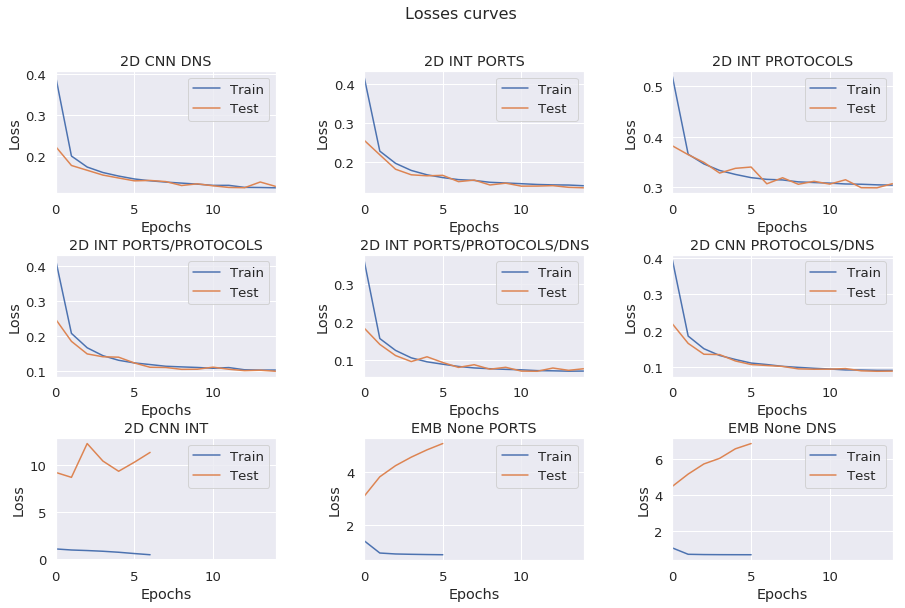

In [167]:
plot_loss_histories(df_histories, names)

## 8.4 Accuracy curves <a id="accuracy_curves"></a>

In [140]:
def plot_accuracy_histories(histories, names):
    fig, axes = plt.subplots(3, 3, figsize=(15, 9))
    fig.subplots_adjust(wspace=0.4, hspace=0.5)
    fig.suptitle('Accuracy curves', fontsize=16)

    for name, ax in zip(names, axes.ravel()):
        columns = ['accuracy_'+name, 'val_accuracy_'+name]
        data = histories[columns]
        # Plot train/val loss
        ax.plot(data['accuracy_'+name])
        ax.plot(data['val_accuracy_'+name])
        ax.set_title('{} {} {}'.format(name.split('_')[0], 
                                       name.split('_')[1],
                                       name.split('_')[2]))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epochs')
        ax.set_ylim([0, 1.1])
        ax.set_xlim([0, data.shape[0]-1])
        ax.legend(['Train', 'Test'], loc='lower right')

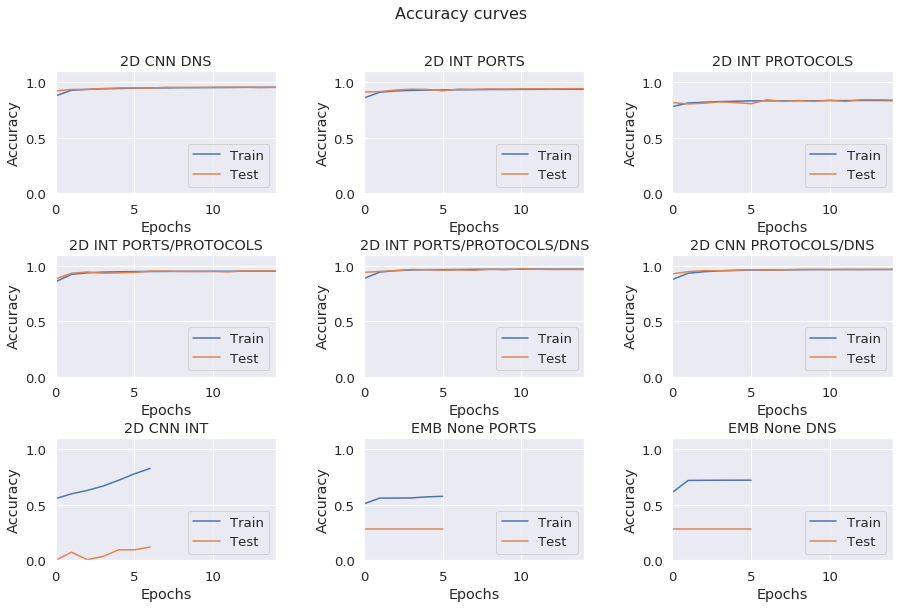

In [168]:
plot_accuracy_histories(df_histories, names)

**Comment** : The curves goes up very quickly as we face a very simple problem. At the first epochs 

## 8.5 Learning rates <a id="learning_rates"></a>

In [142]:
def plot_lr_histories(histories, names):
    fig, axes = plt.subplots(3, 3, figsize=(15, 9))
    fig.subplots_adjust(wspace=0.4, hspace=0.5)
    fig.suptitle('Learning rates evolution', fontsize=16)

    for name, ax in zip(names, axes.ravel()):
        columns = ['lr_'+name]
        data = histories[columns]
        # Plot train/val loss
        ax.plot(data['lr_'+name])
        ax.set_title('{} {} {}'.format(name.split('_')[0], 
                                       name.split('_')[1],
                                       name.split('_')[2]))
        ax.set_ylabel('Learning rate value')
        ax.set_xlabel('Epochs')

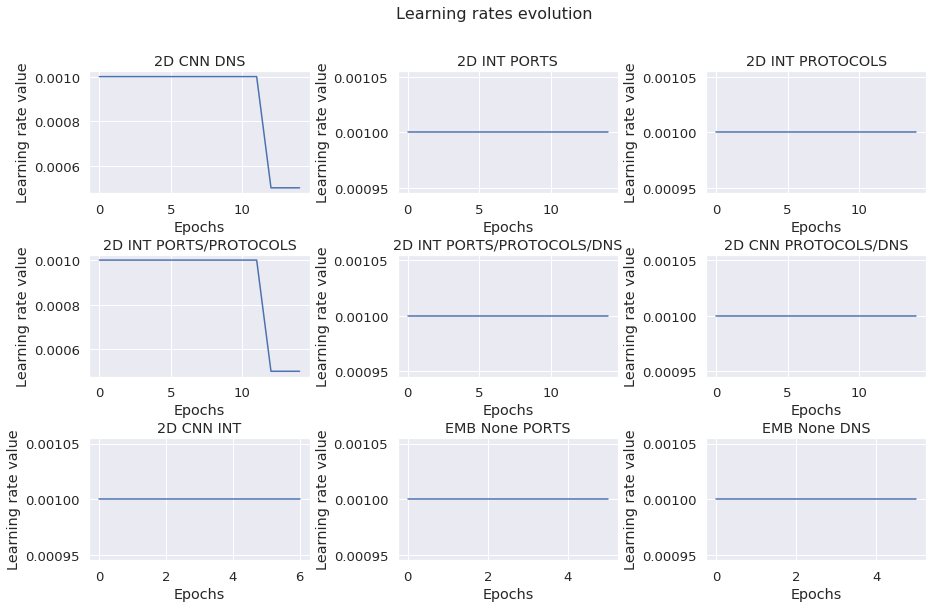

In [143]:
plot_lr_histories(df_histories, names)

**Comment** : Set up weights decay.

## 8.6 Results <a id="results"></a>

In [154]:
def plot_confusion_matrix(y_true, y_preds, names=[]):
    fig, axes = plt.subplots(3, 3, figsize=(15, 9))
    fig.subplots_adjust(wspace=0.4, hspace=0.5)
    fig.suptitle('Confusion matrix on test set', fontsize=16)
    
    labels = np.sort(
        np.unique(
            processing.dataset.iloc[
                test_gen.list_IDs]['label'].value_counts().index.values)
    )
    
    for name, ax, y_pred in zip(names, axes.ravel(), y_preds):
    
        cm = sklearn.metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)

        df_cm = pd.DataFrame(
            cm, index=labels, columns=labels, 
        )
        
        sns.heatmap(df_cm, ax=ax, annot=True, fmt="d", cbar=None)
        ax.set_title('{} {} {}'.format(name.split('_')[0], 
                                       name.split('_')[1],
                                       name.split('_')[2]))
        ax.set_ylabel("Actual label")
        ax.set_xlabel("Predicted label")

In [155]:
def plot_accuracy(accuracies, names):
    fig, axes = plt.subplots(3, 3, figsize=(15, 9))
    fig.subplots_adjust(wspace=0.4, hspace=0.5)
    fig.suptitle('Accuracy on test and validation set', fontsize=16)

    for name, ax in zip(names, axes.ravel()):
        columns = ['acc_val', 'acc_test']
        data = accuracies[accuracies['models'] == name][columns]
        sns.barplot(data=data, ax=ax)
        ax.set_title('{} {} {}'.format(name.split('_')[0], 
                                       name.split('_')[1],
                                       name.split('_')[2]))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Dataset')
        ax.set_xticklabels(['Val', 'Test'])
        ax.set_ylim([0, 1.1])

In [146]:
def plot_accuracy_length(accuracies_length, names):
    fig, axes = plt.subplots(3, 3, figsize=(15, 9))
    fig.subplots_adjust(wspace=0.4, hspace=0.5)
    fig.suptitle('Accuracy in function of packet length on test set', fontsize=16)

    for name, ax in zip(names, axes.ravel()):
        columns = ['total_len', 'acc_test']
        data = accuracies_length[accuracies_length['models'] == name][columns]
        sns.scatterplot(x='total_len', y='acc_test', data=data, ax=ax)
        ax.set_title('{} {} {}'.format(name.split('_')[0], 
                                       name.split('_')[1],
                                       name.split('_')[2]))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Packet length')
        ax.set_ylim([-0.1, 1.1])

In [147]:
def plot_accuracy_layer(accuracies_lX, layer, names):
    fig, axes = plt.subplots(3, 3, figsize=(15, 9))
    fig.subplots_adjust(wspace=0.4, hspace=0.5)
    fig.suptitle('Accuracy in function of layer {} on test set'.format(layer), fontsize=16)

    for name, ax in zip(names, axes.ravel()):
        columns = [layer, 'acc_test']
        data = accuracies_lX[accuracies_lX['models'] == name][columns]
        sns.barplot(x=layer, y='acc_test', data=data, ax=ax)
        ax.set_title('{} {} {}'.format(name.split('_')[0], 
                                       name.split('_')[1],
                                       name.split('_')[2]))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Layer {}'.format(layer))
        ax.set_ylim([-0.1, 1.1])

In [148]:
def plot_accuracy_label(accuracies_label, names):
    fig, axes = plt.subplots(3, 3, figsize=(15, 9))
    fig.subplots_adjust(wspace=0.4, hspace=0.5)
    fig.suptitle('Accuracy in function of label on test set', fontsize=16)

    for name, ax in zip(names, axes.ravel()):
        columns = ['label', 'acc_test']
        data = accuracies_label[accuracies_label['models'] == name][columns]
        sns.barplot(x='label', y='acc_test', data=data, ax=ax)
        ax.set_title('{} {} {}'.format(name.split('_')[0], 
                                       name.split('_')[1],
                                       name.split('_')[2]))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Label')
        ax.set_ylim([-0.1, 1.1])

In [149]:
def plot_accuracy_encrypt(accuracies_encrypt, names):
    fig, axes = plt.subplots(3, 3, figsize=(15, 9))
    fig.subplots_adjust(wspace=0.4, hspace=0.5)
    fig.suptitle('Accuracy in function of encryption on test set', fontsize=16)

    for name, ax in zip(names, axes.ravel()):
        columns = ['encrypt', 'acc_test']
        data = accuracies_encrypt[accuracies_encrypt['models'] == name][columns]
        sns.barplot(x='encrypt', y='acc_test', data=data, ax=ax)
        ax.set_title('{} {} {}'.format(name.split('_')[0], 
                                       name.split('_')[1],
                                       name.split('_')[2]))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Label')
        ax.set_ylim([-0.1, 1.1])

In [150]:
def plot_accuracy_application(accuracies_application, names):
    fig, axes = plt.subplots(3, 3, figsize=(15, 9))
    fig.subplots_adjust(wspace=0.4, hspace=0.5)
    fig.suptitle('Accuracy in function of label on test set', fontsize=16)

    for name, ax in zip(names, axes.ravel()):
        columns = ['application', 'acc_test']
        data = accuracies_application[accuracies_application['models'] == name][columns]
        plot = sns.barplot(x='application', y='acc_test', data=data, ax=ax)
        for item in plot.get_xticklabels():
            item.set_rotation(90)
        ax.set_title('{} {} {}'.format(name.split('_')[0], 
                                       name.split('_')[1],
                                       name.split('_')[2]))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Label')
        ax.set_ylim([-0.1, 1.1])

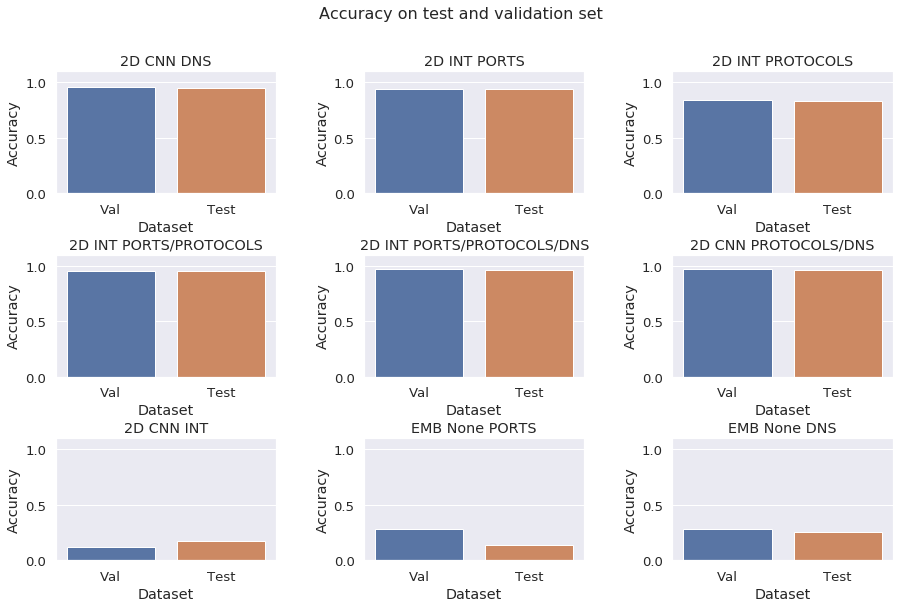

In [169]:
plot_accuracy(df_accuracies, names)

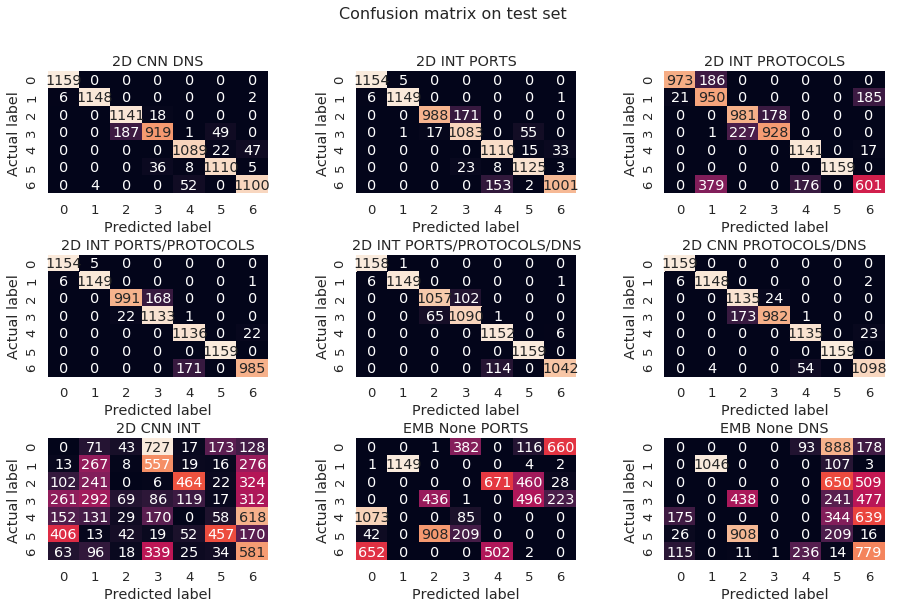

In [170]:
plot_confusion_matrix(processing.dataset['label'].values[test_gen.list_IDs], 
                      y_preds, names=names)

In [157]:
processing.map_dict

{'Chat': 0,
 'Email': 1,
 'File_Transfer': 2,
 'P2P': 3,
 'Streaming': 4,
 'VoIP': 5,
 'Web_Browsing': 6}

**Comment** : The results are impresive! To my mind I barely get this type of result... So I think it's due to data leakage (i.e an information in the data can help to easily classify data in each class). In order to confirm this we need to inspect how the model "sees" the data.

Furthemore, it's really suprising to not get worth result on class where packets as a shorter length because in theory we have least informations.

We can note that I change the lenght of the packets for the baseline model. If the packets length is shorter and focus on header we can better and better results (from 50% accuracy on test set to nearly 70%). So, **the header clearly help the baseline model** and maybe the others models.

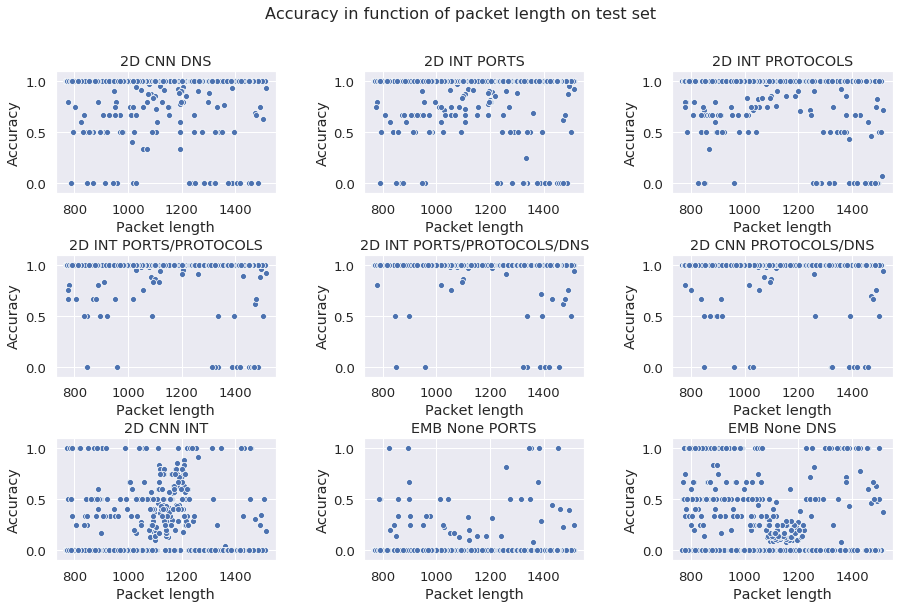

In [171]:
plot_accuracy_length(df_accuracies_len, names)

**Comment** : As we can see the packet length not influe at all on accuracy. So we can confirm our hypothesis about header. We can also confirm this in the EDA part where the header dont seems to change much on mean profile. 

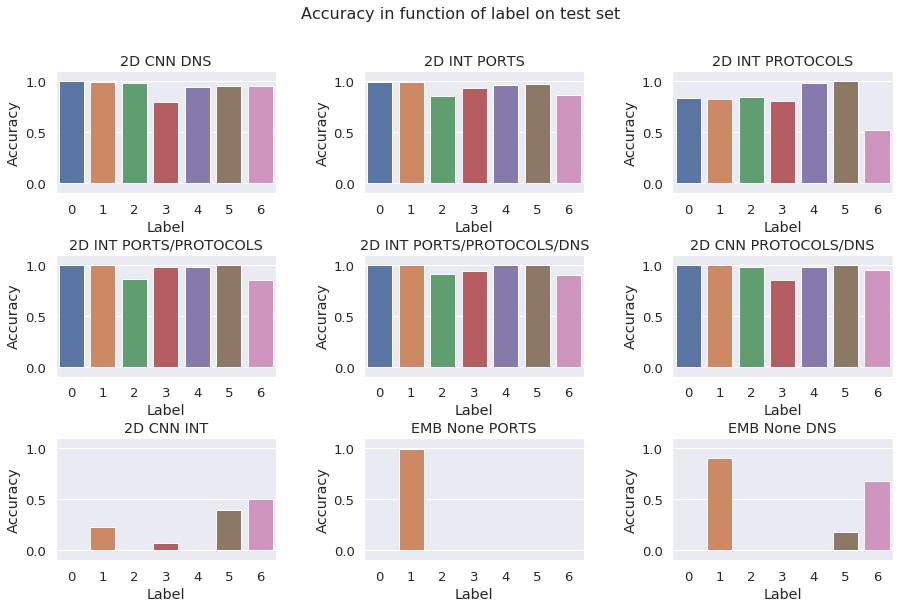

In [172]:
plot_accuracy_label(df_accuracies_label, names)

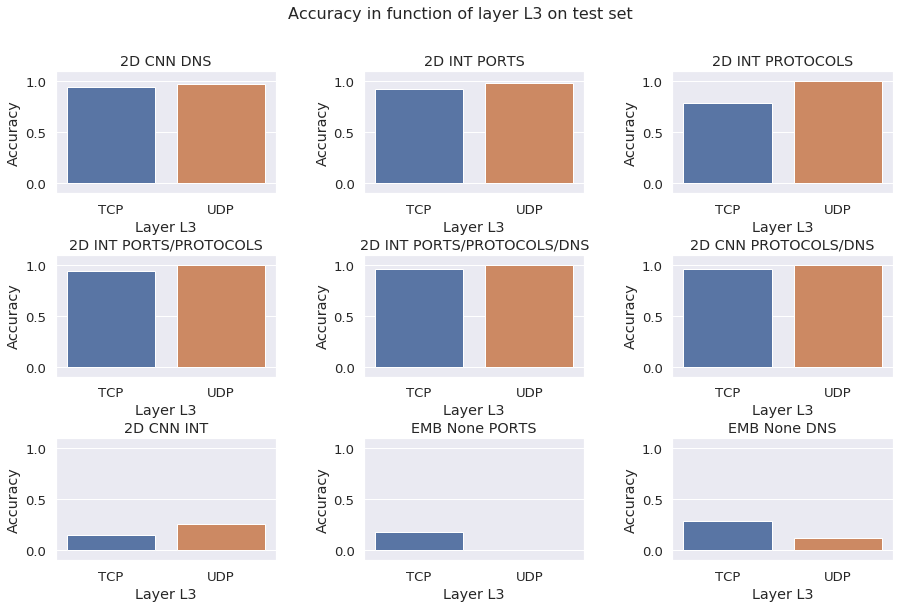

In [174]:
plot_accuracy_layer(df_accuracies_l3, layer='L3', names=names)

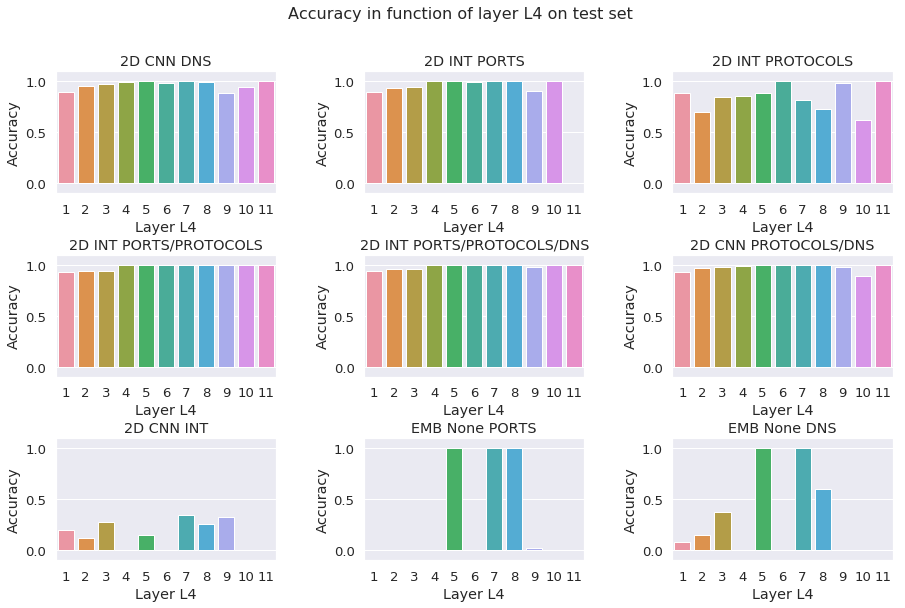

In [175]:
plot_accuracy_layer(df_accuracies_l4, layer='L4', names=names) # Normalizer par rapport au nombre d'elements...

In [176]:
processing.inv_dict_ports

{'BITTORRENT': 9,
 'FTPS': 10,
 'HTTP': 3,
 'IMAPS': 8,
 'IRC': 11,
 'POP3S': 7,
 'QUIC': 6,
 'Raw': 1,
 'SMTPS': 5,
 'SSH': 4,
 'TLS': 2}

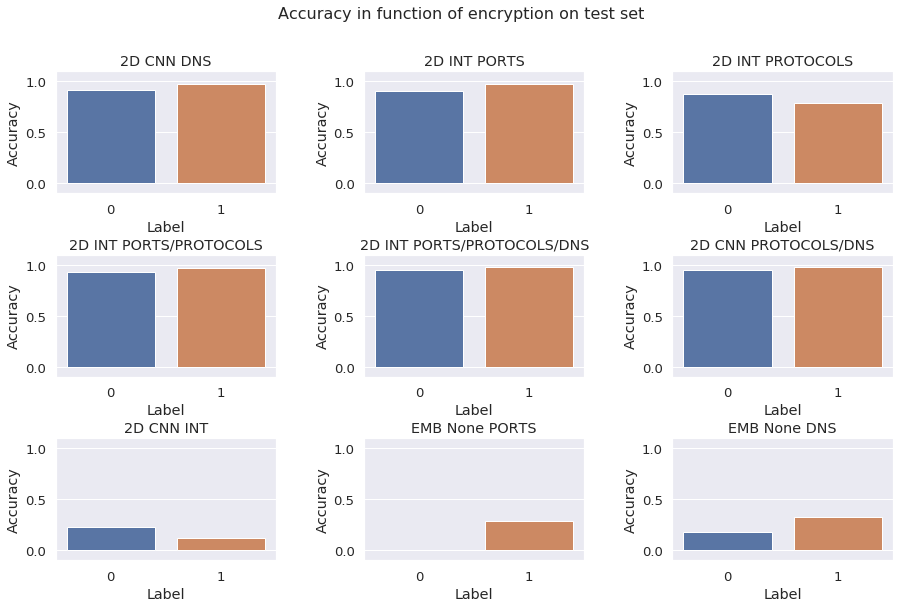

In [177]:
plot_accuracy_encrypt(df_accuracies_encrypt, names=names)

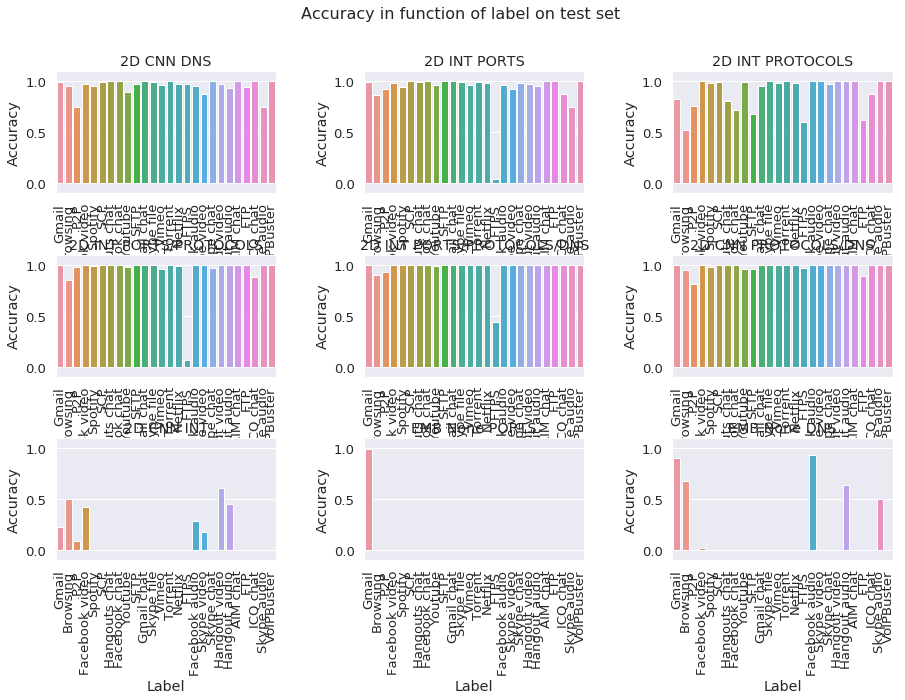

In [178]:
plot_accuracy_application(df_accuracies_application, names=names)

## 8.7 Conclusion <a id="modelisation_conclusion"></a>

To fill.

# 9. Interpretation <a id="interpretation"></a>

**Note** : In this part we will focus on network interpretation and confirm or not what we saw in the results part. We will decompose interpretation in two parts and we will try to answer simple questions.

First part: GradCAM / Guided BackProp / Guided GradCAM / Occlusion Map
- What part of the input is responsible for the output?
- Can we check what the network focuses on given an input image?

Second part : t-SNE projection
- How the network project data into the space?

In [81]:
# Some methods come from https://github.com/eclique/keras-gradcam/blob/master/gradcam_vgg.ipynb
# and are adapted for the class
class Explainer:
    def __init__(self, model):
        self.model = model
        self.guided_model = self.__build_guided_model(model)
        
        self.data_saliency = None
        self.data_occlusion = None
        self.data_tsne = None
        
        self.df_occlusion = pd.DataFrame()
        
        self.data_occlusion_hexa = None
        self.occlusion_map_hexa = None
        
        self.gradcam = None
        self.gb = None
        self.guided_gradcam = None  
        self.occlusion_map = None
        self.tsne_label = None
        self.tsne_projection = None
        
    def __build_guided_model(self, model):
        """Function returning modified model.

        Changes gradient function for all ReLu activations
        according to Guided Backpropagation.
        """
        if "GuidedBackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("GuidedBackProp")
            def _GuidedBackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype) * \
                       tf.cast(op.inputs[0] > 0., dtype)

        g = tf.get_default_graph()
        with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
            new_model = keras.models.clone_model(model)
        return new_model
    
    def deprocess_image(self, x):
        """Same normalization as in:
        https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
        """
        x = x.copy()
        if np.ndim(x) > 3:
            x = np.squeeze(x)
        # normalize tensor: center on 0., ensure std is 0.1
        x -= x.mean()
        x /= (x.std() + 1e-5)
        x *= 0.1

        # clip to [0, 1]
        x += 0.5
        x = np.clip(x, 0, 1)

        # convert to RGB array
        x *= 255
        #K.common.image_dim_ordering()
        #if K.image_dim_ordering() == 'th':
        #    x = x.transpose((1, 2, 0))
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    def normalize(self, x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)
    
    def __guided_backprop(self, layer_name):
        """Guided Backpropagation method for visualizing input saliency."""
        input_imgs = self.guided_model.input
        layer_output = self.guided_model.get_layer(layer_name).output
        grads = K.gradients(layer_output, input_imgs)[0]
        backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
        grads_val = backprop_fn([self.data_saliency, 0])[0]
        
        if(len(grads_val.shape) == 3):
            grads_val = np.lib.pad(grads_val[0, :, 0], 
                (0,int(np.ceil(np.sqrt(grads_val.shape[1])))**2-grads_val.shape[1]), 
                'constant', constant_values=(0))
            grads_val = np.reshape(grads_val, 
                        (1, int(np.sqrt(grads_val.shape[0])), 
                         int(np.sqrt(grads_val.shape[0])), 1))
        
        return grads_val
    
    def __grad_cam(self, cls, layer_name):
        """GradCAM method for visualizing input saliency."""
        y_c = self.model.output[0, cls]
        conv_output = self.model.get_layer(layer_name).output
        grads = K.gradients(y_c, conv_output)[0]
        # Normalize if necessary
        # grads = normalize(grads)
        gradient_function = K.function([self.model.input], [conv_output, grads])

        output, grads_val = gradient_function([self.data_saliency.copy()])
        
        if(len(grads_val.shape) == 3):
            output, grads_val = output[0, :], grads_val[0, :, :]
        elif(len(grads_val.shape) == 4):
            output, grads_val = output[0, :], grads_val[0, :, :, :]

        weights = np.mean(grads_val, axis=(0, 1))
        cam = np.dot(output, weights)
        
        cam = cv2.resize(cam, (self.data_saliency.shape[1], 
                               self.data_saliency.shape[2]), cv2.INTER_LINEAR)
        
        if(len(self.data_saliency.shape) == 3):
            cam = np.lib.pad(cam[0, :], 
                (0,int(np.ceil(np.sqrt(cam.shape[1])))**2-cam.shape[1]), 
                'constant', constant_values=(0))
            cam = np.reshape(cam, (int(np.sqrt(cam.shape[0])), 
                                   int(np.sqrt(cam.shape[0]))))
            
        
        cam = np.maximum(cam, 0)
        cam = cam / cam.max()
        return cam
    
    def fit_saliency(self, data, layer_name, label, cls=-1):
        """Compute saliency using all three approaches.
            -layer_name: layer to compute gradients;
            -cls: class number to localize (-1 for most probable class).
        """
        # Reshape and add 1 in the beggining
        self.data_saliency  = np.reshape(data, 
                                         (1, *data.shape))
        
        y_pred = self.model.predict(self.data_saliency)
        y_pred_label = np.argmax(y_pred, axis=1)[0]
        
        if(label != y_pred_label):
            print("WARNING ! Model don't predict the good label ! Real {}, Predict {}".format(label, 
                                                         y_pred_label))

        print('Model prediction:')
        for classe, proba in enumerate(y_pred[0]):
            print('\t{}\twith probability {:.3f}'.format(classe, proba))
            
        if cls == -1:
            cls = np.argmax(y_pred)
            
        print("Explanation for '{}'".format(cls))

        self.gradcam = np.nan_to_num(self.__grad_cam(cls, layer_name))
        self.gb = np.nan_to_num(self.__guided_backprop(layer_name))
        self.guided_gradcam = self.gb * self.gradcam[..., np.newaxis]
        
        if(len(self.data_saliency.shape) == 3):
            self.data_saliency = np.lib.pad(self.data_saliency[0, :, 0], 
                (0,int(np.ceil(np.sqrt(self.data_saliency.shape[1])))**2-self.data_saliency.shape[1]), 
                'constant', constant_values=(0))
            self.data_saliency = np.reshape(self.data_saliency, 
                      (1, int(np.sqrt(self.data_saliency.shape[0])), 
                       int(np.sqrt(self.data_saliency.shape[0])), 1))
        
    def fit_tsne(self, data, label, layer_name):        
        self.tsne_label = label
        
        intermediate_layer_model = Model(inputs=self.model.input,
                                         outputs=self.model.get_layer(layer_name).output)
       
        data_tsne = intermediate_layer_model.predict(data)
        
        tsne = TSNE(n_components=2, random_state=0)
        self.tsne_projection = tsne.fit_transform(data_tsne)
        
        
    def fit_occlusion(self, data, shape_filter, label): # Mettre assertion pour le filter...
        self.data_occlusion = data.copy()
        
        self.shape_filter = shape_filter # L'integrer comme dans la classe !!!
        self.occlusion_map = np.zeros(data.shape)

        y_pred = self.model.predict(
            np.reshape(data, (1, *data.shape))
        )           
        
        y_pred_label = np.argmax(y_pred, axis=1)[0]

        if(label != y_pred_label):
            print("WARNING ! Model don't predict \
            the good label ! Real {}, Predict {}".format(label, 
                                                         y_pred_label))
            
        if(len(self.data_occlusion.shape) == 2):
            self.__fit_occlusion_1d(data, shape_filter, label)
            dim = int(np.ceil(np.sqrt(self.data_occlusion.shape[0])))

            self.data_occlusion = np.lib.pad(self.data_occlusion[:, 0], 
                    (0,dim**2-self.data_occlusion.size), 
                    'constant', constant_values=(0))
                
            self.data_occlusion = np.reshape(self.data_occlusion, 
                      (int(np.sqrt(self.data_occlusion.shape[0])), 
                       int(np.sqrt(self.data_occlusion.shape[0])), 1))
        elif(len(self.data_occlusion.shape) == 3):
            self.__fit_occlusion_2d(data, shape_filter, label)
            
    def __fit_occlusion_2d(self, data, shape_filter, label):
        x = []
        y = []
        proba = []
        
        # Check if filter is a multiple of the picture in height and width
        # Remplacer cela par un yield pour le 1d et 2d
        if((self.data_occlusion.shape[0]%shape_filter[0] == 0) and 
           (self.data_occlusion.shape[0]%shape_filter[1] == 0)):
            for c in range(self.data_occlusion.shape[-1]):
                for i in range(0, self.data_occlusion.shape[0], shape_filter[0]):
                    for j in range(0, self.data_occlusion.shape[1], shape_filter[1]):
                        data_tmp = self.data_occlusion.copy()
                        data_tmp[i:i+shape_filter[0], j:j+shape_filter[1], c] = 0
                        data_tmp = np.reshape(data_tmp, 
                                              (1, *self.data_occlusion.shape))
                        y_pred = self.model.predict(data_tmp)
                        self.occlusion_map[i:i+shape_filter[0], j:j+shape_filter[1], 
                                      c] = y_pred[0, label]
                        
                        x.append(i)
                        y.append(j)
                        proba.append(y_pred[0, label])
        else:
            print("WARNING ! Shape of filter is not a multiple of the data.")
                        
        self.df_occlusion['x'] = x
        self.df_occlusion['y'] = y
        self.df_occlusion['proba'] = proba

    def __fit_occlusion_1d(self, data, shape_filter, label): # Mettre les assertions
        x = []
        proba = []        
        
        # Check if filter is a multiple of the picture in height and width
        # Ramplacer cela par un yield pour le 1d et le 2d
        if(self.data_occlusion.shape[0]%shape_filter[0] == 0):
            for c in range(self.data_occlusion.shape[-1]):
                for i in range(0, self.data_occlusion.shape[0], shape_filter[0]):
                    data_tmp = self.data_occlusion.copy()
                    data_tmp[i:i+shape_filter[0], c] = 0
                    data_tmp = np.reshape(data_tmp, 
                                          (1, *self.data_occlusion.shape))
                    y_pred = self.model.predict(data_tmp)
                    self.occlusion_map[i:i+shape_filter[0], c] = y_pred[0, label]
                    
                    x.append(i)
                    proba.append(y_pred[0, label])
                    
        else:
            print("WARNING ! Shape of filter is not a multiple of the data.")
                    
        self.occlusion_map = np.lib.pad(self.occlusion_map[:, 0], 
                (0,int(np.ceil(np.sqrt(self.occlusion_map.shape[0])))**2-self.occlusion_map.shape[0]), 
                'constant', constant_values=(y_pred.max()))
        self.occlusion_map = np.reshape(self.occlusion_map, 
                                (int(np.sqrt(self.occlusion_map.shape[0])), 
                                int(np.sqrt(self.occlusion_map.shape[0])), 1))
        
        self.df_occlusion['x'] = x
        self.df_occlusion['proba'] = proba
        
    def __transform_int_to_hexa(self, normalize=True):
        # Regularisation already inserted
        if(normalize):
            data = np.around(self.data_occlusion*255).astype(int)
        else:
            data = np.around(self.data_occlusion).astype(int)
            
        self.data_occlusion_hexa = [str(hex(data.ravel()[i])).split('0x')[-1]
                                    for i in range(data.size)]
        
        self.data_occlusion_hexa = np.array(self.data_occlusion_hexa)
        
        self.data_occlusion_hexa = np.reshape(self.data_occlusion_hexa, 
                                              self.occlusion_map.shape)
        
        self.occlusion_map_hexa = self.occlusion_map
    
    def __transform_bit_to_hexa(self):
        # Regularisation already inserted
        data = self.data_occlusion.astype(str).ravel()

        self.data_occlusion_hexa = [
            str(hex(int("".join(data[i:i+8]),2))).split('x')[-1] 
            for i in range(0, data.size, 8)]
        
        self.occlusion_map_hexa = []

        for i in range(0, self.occlusion_map.size, 8):
            self.occlusion_map_hexa.append(
                self.occlusion_map.ravel()[i:i+8].min())
            
        self.data_occlusion_hexa = np.array(self.data_occlusion_hexa)
        
        self.data_occlusion_hexa = np.lib.pad(self.data_occlusion_hexa, 
                    (0,1600-self.data_occlusion_hexa.size), 
                    'constant', constant_values=(0))
            
        self.data_occlusion_hexa = np.reshape(self.data_occlusion_hexa, 
                                (int(np.sqrt(self.data_occlusion_hexa.shape[0])), 
                                int(np.sqrt(self.data_occlusion_hexa.shape[0])), 1))
            
        self.occlusion_map_hexa = np.array(self.occlusion_map_hexa)
        
        self.occlusion_map_hexa = np.lib.pad(self.occlusion_map_hexa, 
                    (0,1600-self.occlusion_map_hexa.size), 
                    'constant', constant_values=(0))
            
        self.occlusion_map_hexa = np.reshape(self.occlusion_map_hexa, 
                                (int(np.sqrt(self.occlusion_map_hexa.shape[0])), 
                                int(np.sqrt(self.occlusion_map_hexa.shape[0])), 1))
    

    def __get_ranges(self, index, limit, padding=0, axis=0):
        condition_min = (index-padding >= 0)                
        condition_max = (index+self.shape_filter[axis]+padding < limit)
        
        if(condition_max):
            range_max = index+self.shape_filter[axis]+padding
            if(condition_min):
                range_min = index - padding
            else:
                range_min = 0
        else:
            #range_max = self.occlusion_map_hexa.size - 1
            range_max = self.occlusion_map_hexa.shape[axis] - 1
            if(condition_min):
                range_min = index - padding
            else:
                range_min = 0
        return range_min, range_max
    
    def plot_occlusion_block(self, block=0, form='int',
                             padding=0, 
                             fontsize=8, figsize=(3, 5),
                             normalize=True):
        
        proba_values = self.df_occlusion['proba'].value_counts().index.values
        proba = np.partition(proba_values, block)[block]
        
        i = self.df_occlusion[
            self.df_occlusion['proba'] == proba]['x'].iloc[0].astype(int)
        
        # Convert data to hexa
        if(form == 'bit'):
            self.__transform_bit_to_hexa()
        else:
            self.__transform_int_to_hexa(normalize=True)
        
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        
        if(len(self.shape_filter) == 1):
            if(form == 'bit'):
                i = int(i/8)
                
            print("Coordinates are {}".format(i))
            
            range_min, range_max = self.__get_ranges(
                i, limit=self.occlusion_map_hexa.size, 
                padding=padding, axis=0)

            sns.heatmap(
                # Enlever [:, :, 0]
                np.reshape(self.occlusion_map_hexa.ravel()[range_min:range_max], 
                           (1, range_max-range_min)),
                annot=np.reshape(self.data_occlusion_hexa.ravel()[range_min:range_max], 
                           (1, range_max-range_min)), 
                fmt='', ax=ax, annot_kws={"fontsize":fontsize},
                xticklabels=[idx for idx in range(range_min, range_max)],
                vmin=proba, vmax=1.0)
        else:
            j = self.df_occlusion[
                self.df_occlusion['proba'] == proba]['y'].iloc[0].astype(int)
            
            if(form == 'bit'):
                i = int(i/8)
                j = int(j/8)
        
            print("Coordinates are {},{}".format(i, j))
            
            range_i_min, range_i_max = self.__get_ranges(
                i, limit=self.occlusion_map_hexa.shape[0], 
                padding=padding, axis=0)
            range_j_min, range_j_max = self.__get_ranges(
                j, limit=self.occlusion_map_hexa.shape[1], 
                padding=padding, axis=1)
            # Enlever [:, :, 0]
            
            sns.heatmap(
                self.occlusion_map_hexa[range_i_min:range_i_max, range_j_min:range_j_max][:, :, 0], 
                annot=self.data_occlusion_hexa[range_i_min:range_i_max, range_j_min:range_j_max][:, :, 0], 
                fmt='', ax=ax, annot_kws={"fontsize":fontsize},
                yticklabels=[idx for idx in range(range_i_min, range_i_max)],
                xticklabels=[idx for idx in range(range_j_min, range_j_max)],
                vmin=proba, vmax=1.0)
        
        
    def plot_occlusion(self):
        fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))
        
        sns.heatmap(self.data_occlusion[:, :, 0], linewidths=.05, ax=axes[0])
        axes[0].set_title("Data")
        
        sns.heatmap(self.occlusion_map[:, :, 0], linewidths=.05, ax=axes[1])
        axes[1].set_title("Occlusion map")
        
    def plot_tsne(self):
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        sns.scatterplot(x=self.tsne_projection[:,0], 
                        y=self.tsne_projection[:,1], 
                        hue=self.tsne_label,
                        ax=ax)
        
        ax.set_title("T-SNE projection")
        ax.set_xlabel("First component")
        ax.set_ylabel("Second component")
        
    def plot_silency(self):
        
        # Plot more information such as class ...etc
        fig, axes = plt.subplots(1, 3, figsize=(10, 5.5))

        axes[0].set_title('GradCAM')
        axes[0].axis('off')
        axes[0].imshow(self.data_saliency[0][:,:,0])
        axes[0].imshow(self.gradcam, cmap='jet', alpha=0.5)
        
        axes[1].set_title('Guided Backprop')
        axes[1].axis('off')
        axes[1].imshow(
            np.flip(self.deprocess_image(self.gb[0]), -1)[:, :, 0]
        )
        
        axes[2].set_title('Guided GradCAM')
        axes[2].axis('off')
        axes[2].imshow(
            np.flip(self.deprocess_image(self.guided_gradcam[0]), -1)[:, :, 0]
        )

## 9.1 Input space <a id="input_space"></a>

*Note : For each model we will studies the impact of the packet length, label and representation (bit or int). For each part we will create variation in one parameter and fixe the others. For GradCAM we take the last layer before the fully connected.*

### 9.1.1 CNN 2D INT <a id="input_space_cnn_2d_int"></a>

In [82]:
# Load data
data_array = np.load("data_array/data_array_{}_2d_int.npy".format(GROUP))#, mmap_mode='r')

# Apply under sampling on data_array
#data_array = data_array[processing.dataset['index'].values]
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='int')

# Init model
explainer = Explainer(model_2d_cnn_int)

#### 9.1.1.1 Class impact <a id="input_space_cnn_2d_int_class"></a>

In [ ]:
for k, v in processing.map_dict.items():
    # Get data
    max_length = processing.dataset.iloc[
        test_gen.list_IDs][processing.dataset['label'] == v]['total_len'].max()
    
    condition = ((processing.dataset['total_len'] == max_length) 
                 & (processing.dataset['label'] == v))
    df = processing.dataset.iloc[test_gen.list_IDs][condition]
    
    index = np.random.choice(df.index.values)
    data_index = data_array[index] / 255.

    explainer.fit_saliency(data_index, 
                           'res5b1_relu',
                           label=v, 
                           cls=-1)
    explainer.fit_occlusion(data_index,
                           shape_filter=(2, 2),
                           label=v)
    print("Frame at index {} name label : {}".format(index, k))
    explainer.plot_silency()
    explainer.plot_occlusion()
    explainer.plot_occlusion_block(form='int', block=0, 
                           padding=11, fontsize=11, figsize=(11, 4), 
                            normalize=True)
    plt.show()

**Comment** : Without suprise the last conv layer seems to focus more on header. Even if the class tends to have higher packet length.

#### 9.1.1.2 Packet length <a id="input_space_cnn_2d_int_length"></a>

In [ ]:
# The range of packet length we will studies
ranges = [(501, 1000), (1001, 1536)]

for t in ranges:
    # Get data
    condition = ((processing.dataset['total_len'] >= t[0]) & 
                 (processing.dataset['total_len'] <= t[1]))
    df = processing.dataset.iloc[test_gen.list_IDs][condition]
    
    index = np.random.choice(df.index.values)
    data_index = data_array[index] / 255.

    explainer.fit_saliency(data_index, 
                           'res5b1_relu',
                           label=processing.dataset.iloc[index]['label'], 
                           cls=-1)
    explainer.fit_occlusion(data_index,
                           shape_filter=(2, 2),
                           label=processing.dataset.iloc[index]['label'])
    
    print("Frame at index {} name label : {}".format(
        index,
        list(processing.map_dict.keys())[processing.dataset.iloc[index]['label']])
         )
    print("Packet length : {}".format(processing.dataset.iloc[index]['total_len']))
    explainer.plot_silency()
    explainer.plot_occlusion()
    explainer.plot_occlusion_block(form='int', block=0,
                           padding=11, fontsize=11, figsize=(11, 4), 
                            normalize=True)
    plt.show()

**Comment** : The packet length not influe on where the network is "looking". The packet header seems to be a very discriminative part for the network.

### 9.1.2 CNN 2D BIT <a id="input_space_cnn_2d_bit"></a>

In [85]:
gc.collect()

382481

In [86]:
# Load data
data_array = np.load("data_array/data_array_{}_2d_bit.npy".format(GROUP))#, mmap_mode='r')

# Apply under sampling on data_array
#data_array = data_array[processing.dataset['index'].values]
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='bit')

# Init model
explainer = Explainer(model_2d_cnn_bit)

#### 9.1.2.1 Class impact <a id="input_space_cnn_2d_bit_class"></a>

In [ ]:
for k, v in processing.map_dict.items():
    # Get data
    max_length = processing.dataset.iloc[
        test_gen.list_IDs][processing.dataset['label'] == v]['total_len'].max()
    
    condition = ((processing.dataset['total_len'] == max_length) 
                 & (processing.dataset['label'] == v))
    df = processing.dataset.iloc[test_gen.list_IDs][condition]
    
    index = np.random.choice(df.index.values)
    data_index = data_array[index]

    explainer.fit_saliency(data_index, 
                           'res5b1_relu',
                           label=v, 
                           cls=-1)
    explainer.fit_occlusion(data_index,
                           shape_filter=(3, 3),
                           label=v)
    print("Frame at index {} with name label : {}".format(index, k))
    explainer.plot_silency()
    explainer.plot_occlusion()
    explainer.plot_occlusion_block(form='bit', block=0, 
                           padding=11, fontsize=11, figsize=(11, 4), 
                            normalize=False)
    plt.show()

#### 9.1.2.2 Packet length <a id="input_space_cnn_1d_int_length"></a>

In [ ]:
# The range of packet length we will studies
ranges = [(501, 1000), (1001, 1536)]

for t in ranges:
    # Get data
    condition = ((processing.dataset['total_len'] >= t[0]) & 
                 (processing.dataset['total_len'] <= t[1]))
    df = processing.dataset.iloc[test_gen.list_IDs][condition]
    
    index = np.random.choice(df.index.values)
    data_index = data_array[index]

    explainer.fit_saliency(data_index, 
                           'res5b1_relu',
                           label=processing.dataset.iloc[index]['label'], 
                           cls=-1)
    explainer.fit_occlusion(data_index,
                           shape_filter=(3, 3),
                           label=processing.dataset.iloc[index]['label'])
    
    print("Frame at index {} with name label : {}".format(
        index,
        list(processing.map_dict.keys())[processing.dataset.iloc[index]['label']])
         )
    print("Packet length : {}".format(processing.dataset.iloc[index]['total_len']))
    explainer.plot_silency()
    explainer.plot_occlusion()
    explainer.plot_occlusion_block(form='bit', block=0, 
                           padding=11, fontsize=11, figsize=(11, 4), 
                            normalize=False)
    plt.show()

### 9.1.3 CNN 1D INT<a id="input_space_cnn_1d_int"></a>

In [89]:
gc.collect()

255353

In [90]:
# Load data
data_array = np.load("data_array/data_array_{}_1d_int.npy".format(GROUP))#, mmap_mode='r')

# Apply under sampling on data_array
#data_array = data_array[processing.dataset['index'].values]
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='int')

# Init model
explainer = Explainer(model_1d_cnn_int)

#### 9.1.3.1 Class impact <a id="input_space_cnn_2d_bit_class"></a>

In [ ]:
for k, v in processing.map_dict.items():
    # Get data
    max_length = processing.dataset.iloc[
        test_gen.list_IDs][processing.dataset['label'] == v]['total_len'].max()
    
    condition = ((processing.dataset['total_len'] == max_length) 
                 & (processing.dataset['label'] == v))
    df = processing.dataset.iloc[test_gen.list_IDs][condition]
    
    index = np.random.choice(df.index.values)
    data_index = data_array[index] / 255.

    explainer.fit_saliency(data_index, 
                           'res5b1_relu',
                           label=v, 
                           cls=-1)
    explainer.fit_occlusion(data_index,
                           shape_filter=(3,),
                           label=v)
    print("Frame at index {} with name label : {}".format(index, k))
    explainer.plot_silency()
    explainer.plot_occlusion()
    explainer.plot_occlusion_block(form='int', block=0,
                           padding=11, fontsize=11, figsize=(11, 1), 
                            normalize=True)
    plt.show()

#### 9.1.3.2 Packet length <a id="input_space_cnn_1d_int_length"></a>

In [ ]:
# The range of packet length we will studies
ranges = [(501, 1000), (1001, 1536)]

for t in ranges:
    # Get data
    condition = ((processing.dataset['total_len'] >= t[0]) & 
                 (processing.dataset['total_len'] <= t[1]))
    df = processing.dataset.iloc[test_gen.list_IDs][condition]
    
    index = np.random.choice(df.index.values)
    data_index = data_array[index] / 255.

    explainer.fit_saliency(data_index, 
                           'res5b1_relu',
                           label=processing.dataset.iloc[index]['label'], 
                           cls=-1)
    explainer.fit_occlusion(data_index,
                           shape_filter=(3,),
                           label=processing.dataset.iloc[index]['label'])
    
    print("Frame at index {} with name label : {}".format(
        index,
        list(processing.map_dict.keys())[processing.dataset.iloc[index]['label']])
         )
    print("Packet length : {}".format(processing.dataset.iloc[index]['total_len']))
    explainer.plot_silency()
    explainer.plot_occlusion()
    explainer.plot_occlusion_block(form='int', block=0,
                           padding=11, fontsize=11, figsize=(11, 1), 
                            normalize=True)
    plt.show()

### 9.1.4 CNN 1D BIT<a id="input_space_cnn_1d_bit"></a>

In [93]:
gc.collect()

54558

In [94]:
# Load data
data_array = np.load("data_array/data_array_{}_1d_bit.npy".format(GROUP))#, mmap_mode='r')

# Apply under sampling on data_array
#data_array = data_array[processing.dataset['index'].values]
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='bit')

# Init model
explainer = Explainer(model_1d_cnn_bit)

#### 9.1.4.1 Class impact <a id="input_space_cnn_1d_bit_class"></a>

In [ ]:
for k, v in processing.map_dict.items():
    # Get data
    max_length = processing.dataset.iloc[
        test_gen.list_IDs][processing.dataset['label'] == v]['total_len'].max()
    
    condition = ((processing.dataset['total_len'] == max_length) 
                 & (processing.dataset['label'] == v))
    df = processing.dataset.iloc[test_gen.list_IDs][condition]
    
    index = np.random.choice(df.index.values)
    data_index = data_array[index]

    explainer.fit_saliency(data_index, 
                           'res5b1_relu',
                           label=v, 
                           cls=-1)
    explainer.fit_occlusion(data_index,
                           shape_filter=(3,),
                           label=v)
    print("Frame at index {} with name label : {}".format(index, k))
    explainer.plot_silency()
    explainer.plot_occlusion()
    explainer.plot_occlusion_block(form='bit', block=0,
                           padding=11, fontsize=11, figsize=(11, 1), 
                            normalize=False)
    plt.show()

#### 9.1.4.2 Packet length <a id="input_space_cnn_1d_int_length"></a>

In [ ]:
# The range of packet length we will studies
ranges = [(501, 1000), (1001, 1536)]

for t in ranges:
    # Get data
    condition = ((processing.dataset['total_len'] >= t[0]) & 
                 (processing.dataset['total_len'] <= t[1]))
    df = processing.dataset.iloc[test_gen.list_IDs][condition]
    
    index = np.random.choice(df.index.values)
    data_index = data_array[index]

    explainer.fit_saliency(data_index, 
                           'res5b1_relu',
                           label=processing.dataset.iloc[index]['label'], 
                           cls=-1)
    explainer.fit_occlusion(data_index,
                           shape_filter=(3,),
                           label=processing.dataset.iloc[index]['label'])
    
    print("Frame at index {} with name label : {}".format(
        index, 
        list(processing.map_dict.keys())[processing.dataset.iloc[index]['label']])
         )
    print("Packet length : {}".format(processing.dataset.iloc[index]['total_len']))
    explainer.plot_silency()
    explainer.plot_occlusion()
    explainer.plot_occlusion_block(form='bit', block=0,
                           padding=11, fontsize=11, figsize=(11, 1), 
                            normalize=False)
    plt.show()

## 9.2 Projected space <a id="projected_space"></a>

In [97]:
# Prepare dataset
processing.int_to_label()
label_values = processing.dataset.iloc[test_gen.list_IDs]['label'].values

### 9.2.1 CNN 2D INT <a id="projected_space_cnn_2d_int"></a>

In [98]:
gc.collect()

18897

In [99]:
# Load data
data_array = np.load("data_array/data_array_{}_2d_int.npy".format(GROUP))#, mmap_mode='r')

# Apply under sampling on data_array
#data_array = data_array[processing.dataset['index'].values] / 255.
data_array = data_array / 255.
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='int')

# Init model
explainer = Explainer(model_2d_cnn_int)

In [100]:
explainer.fit_tsne(data=data_array[test_gen.list_IDs], 
                   label=label_values, 
                   layer_name='pool5')

In [ ]:
explainer.plot_tsne()

In [ ]:
for layer in ['L3', 'L4', 'total_len']:
    print('Visualization of data in function of {}'.format(layer))
    explainer.tsne_label = processing.dataset.iloc[
        test_gen.list_IDs][layer].fillna('None').values
    explainer.plot_tsne()
    plt.show()

**Comment** : I didn't plot here T-SNE projection in function of IP adress and port because the legend is too long. Furthemore when I plot it the adress doesn't seems to be linked with the clusters obeserved. One clusters can have various address and ports linked to it.

### 9.2.2 CNN 2D BIT <a id="projected_space_cnn_2d_bit"></a>

In [103]:
# Load data
data_array = np.load("data_array/data_array_{}_2d_bit.npy".format(GROUP))#, mmap_mode='r')

# Apply under sampling on data_array
#data_array = data_array[processing.dataset['index'].values]
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='bit')

# Init model
explainer = Explainer(model_2d_cnn_bit)

In [104]:
explainer.fit_tsne(data=data_array[test_gen.list_IDs], 
                   label=label_values, 
                   layer_name='pool5')

In [ ]:
explainer.plot_tsne()

In [ ]:
for layer in ['L3', 'L4', 'total_len']:
    print('Visualization of data in function of {}'.format(layer))
    explainer.tsne_label = processing.dataset.iloc[
        test_gen.list_IDs][layer].fillna('None').values
    explainer.plot_tsne()
    plt.show()

### 9.2.3 CNN 1D INT<a id="projected_space_cnn_1d_int"></a>

In [107]:
gc.collect()

23794

In [108]:
# Load data
data_array = np.load("data_array/data_array_{}_1d_int.npy".format(GROUP))#, mmap_mode='r')

# Apply under sampling on data_array
#data_array = data_array[processing.dataset['index'].values] / 255.
data_array = data_array / 255.
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='int')

# Init model
explainer = Explainer(model_1d_cnn_int)

In [109]:
explainer.fit_tsne(data=data_array[test_gen.list_IDs], 
                   label=label_values, 
                   layer_name='pool5')

In [ ]:
explainer.plot_tsne()

In [ ]:
for layer in ['L3', 'L4', 'total_len']:
    print('Visualization of data in function of {}'.format(layer))
    explainer.tsne_label = processing.dataset.iloc[
        test_gen.list_IDs][layer].fillna('None').values
    explainer.plot_tsne()
    plt.show()

### 9.2.4 CNN 1D BIT<a id="projected_space_cnn_1d_bit"></a>

In [112]:
gc.collect()

11531

In [ ]:
# Load data
data_array = np.load("data_array/data_array_{}_1d_bit.npy".format(GROUP))#, mmap_mode='r')

# Apply under sampling on data_array
#data_array = data_array[processing.dataset['index'].values]
processing.fit_processing_header(
    header=HEADER, data_array=data_array, form='bit')

# Init model
explainer = Explainer(model_1d_cnn_bit)

In [ ]:
explainer.fit_tsne(data=data_array[test_gen.list_IDs], 
                   label=label_values, 
                   layer_name='pool5')

In [ ]:
explainer.plot_tsne()

In [ ]:
for layer in ['L3', 'L4', 'total_len']:
    print('Visualization of data in function of {}'.format(layer))
    explainer.tsne_label = processing.dataset.iloc[
        test_gen.list_IDs][layer].fillna('None').values
    explainer.plot_tsne()
    plt.show()

# 10. Conclusion <a id="conclusion"></a>

# 10. Reference <a id="references"></a>